In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
# plot ohlc bars:
from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as mdates

# Algoritmo de inversión y backtesting completo

**Bloque 1**

Genera datos sintéticos para 500 "caminos" históricos alternativos. 

    - La longitud de la serie generada deberá ser igual a la del stock_data original. 
    
    - Deberás respetar la composición del índice en cada instante (conforme está en ibex_data.csv)
 
Generación de señales del algoritmo dinámico

    - Programa el algoritmo en python, generando las señales de compra venta con este algoritmo. 
    
    - El algoritmo se basa en la reversión a la media de los percentiles del Alpha de Jensen. 
    
    - Se generará una señal de compra cuando el percentil del instante actual se encuentre por debajo del percentil 15. Y se generará una señal de venta cuando el percentil del instante actual se encuentre por encima del percentil 85. No hace falta que calcules los precios objetivo de compra o venta.
    
    - Tanto la compra como la venta se realizarán el día siguiente a la generación de la señal. Se venderá en precio de apertura y se comprará a precio de cierre. El capital de la venta en apertura estará disponible para la compra en subasta de cierre.
    
    - Realiza este ejercicio con una configuración estática 85 - 15 y ventana de 30 datos.

La asignación de capital disponible se realizará por el menor importe de los dos siguientes:

    - Límite de asignación: se calculará en función del efectivo negociado (volumen * precio). Aquellas acciones que se encuentren en el tercio de mayor negociación podrán recibir hasta el 10% del patrimonio. Aquellas que se encuentren en el tercio central, hasta el 5%. Y aquellas acciones que se encuentre en el tercio inferior, hasta el 2% del capital. Deberás calcular qué acciones se encuentran en qué tercio y trabajar en consecuencia. El cálculo se debe realizar trimestralmente, con los datos del trimestre anterior.
    
    - Límite por umbral de arrastre (presunción de ejecución): Asumimos que podemos ocupar como máximo un 10% de la negociación de la subasta. En las subastas de apertura se negocia en media un 30% del volumen diario. En la subasta de cierre un 40%. Para calcular el volumen negociado se calculará la media del volumen usando la misma ventana con la que estemos trabajando en el algoritmo.

Implementación de supuestos realistas:

    - Capital bajo gestión, 10 millones de euros.

    - No podemos comprar fracciones de acciones (redondeamos siempre hacia abajo el número de acciones a comprar).

    - Las comisiones serán el mayor importe entre 8€ por operación (16 compra + venta) y 0.0008 * efectivo de la operación. Las comisiones se aplican tanto en la compra, como en la venta.
    
    - El stop loss se basa en la intensidad de la señal, por lo que no se producirá la venta hasta que el percentil alcance el 85.
    
    - Si la acción sale del índice, y estamos invertidos, hay que vender el último día a precio de cierre.
    
Calcula el resultado del algoritmo, obteniendo los siguiente gráficos para los datos sintéticos generados. No quiero que calcules periodos de 1, 3 y 5 años. Quiero que calcules el resultado para cada una de las series sintéticas. Comenta los resultados.

### Leer y ordenar los datos

Datos obtenidos de:
 - Ibex35 con dividendos: de investing https://es.investing.com/indices/ibex-total-return-historical-data
 - EONIA: de banco central europeo https://data.ecb.europa.eu/data/datasets/FM/FM.M.U2.EUR.4F.MM.EONIA.HSTA 


In [2]:
stocks_ibex_data = pd.read_csv('ibex_data.csv')
stocks_ibex_close_data = stocks_ibex_data.pivot(index='date', columns='ticker', values='close')
stocks_ibex_open_data = stocks_ibex_data.pivot(index='date', columns='ticker', values='open')
stocks_ibex_volume_data = stocks_ibex_data.pivot(index='date', columns='ticker', values='vol')

# ffill all nan between first valid index of stock and last valid index
stocks_ibex_close_data.ffill(limit_area='inside', inplace=True)
stocks_ibex_open_data.ffill(limit_area='inside', inplace=True)
stocks_ibex_volume_data.ffill(limit_area='inside', inplace=True)

# index as date
stocks_ibex_close_data.index = pd.to_datetime(stocks_ibex_close_data.index)
stocks_ibex_open_data.index = pd.to_datetime(stocks_ibex_open_data.index)
stocks_ibex_volume_data.index = pd.to_datetime(stocks_ibex_volume_data.index)

stocks_ibex_close_data.head()

ticker,A3TV,ABE,ABG,ABG.P_0,ABG.P_1,ACS,ACX,ACX_0,AENA,AGS,...,SGRE,SGRE_0,TEF,TEM,TL5,TRE,UNF,VIS,VIS_0,ZEL
date,,,,,,,,,,,,,,,,,,,,,
2004-01-02,NaN,3.358035,NaN,NaN,NaN,6.497078,NaN,5.274940,NaN,NaN,...,NaN,6.433393,4.844478,7.99,NaN,NaN,4.05,NaN,NaN,5.50
2004-01-05,NaN,3.312533,NaN,NaN,NaN,6.549971,NaN,5.274940,NaN,NaN,...,NaN,6.441683,4.920970,8.05,NaN,NaN,4.01,NaN,NaN,5.56
2004-01-07,NaN,3.321633,NaN,NaN,NaN,6.532340,NaN,5.240122,NaN,NaN,...,NaN,6.242712,5.014460,8.20,NaN,NaN,3.93,NaN,NaN,5.50
2004-01-08,NaN,3.312533,NaN,NaN,NaN,6.532340,NaN,5.283645,NaN,NaN,...,NaN,6.251003,5.124948,8.31,NaN,NaN,3.91,NaN,NaN,5.51
2004-01-09,NaN,3.303433,NaN,NaN,NaN,6.470631,NaN,5.205304,NaN,NaN,...,NaN,6.209551,5.022959,8.30,NaN,NaN,3.92,NaN,NaN,5.55


In [3]:
ibex35_index = pd.read_csv('IBEX35_Div.csv')
ibex35_index['date'] = pd.to_datetime(ibex35_index['Fecha'], format='%d.%m.%Y')
ibex35_index = ibex35_index.loc[ibex35_index['date'] >= '2004-01-01']
ibex35_index.set_index('date', inplace=True)
ibex35_index.drop(columns=['Fecha'], inplace=True)
ibex35_index = ibex35_index.sort_index()
ibex35_index['close'] = ibex35_index['Último'].str.replace('.', '')
ibex35_index['close'] = ibex35_index['close'].str.replace(',', '.')
ibex35_index['close'] = pd.to_numeric(ibex35_index['close'])
ibex35_index['open'] = ibex35_index['Apertura'].str.replace('.', '')
ibex35_index['open'] = ibex35_index['open'].str.replace(',', '.')
ibex35_index['open'] = pd.to_numeric(ibex35_index['open'])
ibex35_index.drop(columns=['Último', 'Apertura', 'Máximo', 'Mínimo', 'Vol.', '% var.'], inplace=True)
ibex35_index = ibex35_index.reindex(stocks_ibex_close_data.index, method='ffill')

# take same date range as stocks_ibex_data
ibex35_index = ibex35_index.loc[stocks_ibex_data['date'].min():stocks_ibex_data['date'].max()]

# index as date
ibex35_index.index = pd.to_datetime(ibex35_index.index)

ibex35_index.head()

,close,open
date,,
2004-01-02,11162.3,11162.3
2004-01-05,11212.3,11212.3
2004-01-07,11216.7,11216.7
2004-01-08,11260.6,11260.6
2004-01-09,11234.5,11234.5


In [4]:
eonia = pd.read_csv('EONIA.csv')
eonia['date'] = pd.to_datetime(eonia['DATE'])
eonia.set_index('date', inplace=True)
eonia.drop(columns=['DATE', 'TIME PERIOD'], inplace=True)
eonia = eonia.reindex(ibex35_index.index, method='ffill')
eonia = eonia.loc[stocks_ibex_data['date'].min():stocks_ibex_data['date'].max()]
eonia.index = pd.to_datetime(eonia.index)

eonia.head()

,Eonia
date,
2004-01-02,2.0567
2004-01-05,2.0567
2004-01-07,2.0567
2004-01-08,2.0567
2004-01-09,2.0567


In [5]:
print(f'ibex35_index shape: {ibex35_index.shape[0]}')
print(f'stocks_ibex_close_data shape: {stocks_ibex_close_data.shape[0]}')
print(f'eonia shape: {eonia.shape[0]}')

ibex35_index shape: 3953
stocks_ibex_close_data shape: 3953
eonia shape: 3953


### Generción de datos sintéticos

La idea para generar datos sintéticos es la siguiente :

 - Generar datos sintéticos de los precios de cierre y los gaps por separado teniendo en cuenta la correlacion con el resto de activos con np.random.multivariate_normal. Los precios de apertura seran los de cierre + gap.
 - Para cada segmento en donde se mantiene la misma configuración de activos en el IBEX35 calcularemos la covarianza y generaremos datos sinteticos correlados en función de estas covariznzas
 - Para generar el volumen tomaremos las correlaciones que tiene el volumen real con los retornos diarios y en funcion de esta correlacón generaremos volumenes correlados a los precios sintéticos (decisión tomada después de varias iteraciones probando diferentes metodos)
 - Para generar el ibex sintético se hará una media ponderada por volumen operado de los datos sintéticos.

In [6]:
def generate_synthetic_correlated_data(log_returns_df, n_samples=500):
    """
    Generate synthetic data for the stocks in the log_returns_df. The data is generated using the mean and covariance 
    of the stocks in the log_returns_df.
    """
    res = []
    for _ in range(n_samples):
        stocks_synthetic_data = pd.DataFrame(columns=log_returns_df.columns, index=log_returns_df.index, dtype = float)

        cambios = log_returns_df.notna().astype(int).diff().ne(0).any(axis=1)
        indices_cambio = log_returns_df.index[cambios] # aqui separamos en ventanas donde se mantiene el mismo conjunto de stocks
        cambios = log_returns_df.index.get_indexer(indices_cambio)
        cambios = np.append(cambios, len(log_returns_df.index))

        act_index = cambios[1]
        for next_index in cambios[2:]:
            # take all stocks with values not nan at the same days
            stocks_data = log_returns_df.iloc[act_index:next_index, :]
            stocks_data = stocks_data.dropna(axis=1, how = 'all')    

            window_size = len(stocks_data)  
            mean = stocks_data.mean()

            if window_size == 1:
                synthetic_data = np.random.normal(mean.mean(), np.abs(mean.mean()) * 0.02, (1, len(mean)))
            else:
                cov = stocks_data.cov() + np.eye(len(mean)) * 1e-6
                synthetic_data = np.random.multivariate_normal(mean, cov, window_size)

            stocks_synthetic_data.loc[stocks_data.index, stocks_data.columns] = synthetic_data.astype(float)

            act_index = next_index
        res.append(stocks_synthetic_data)

    return res   

In [7]:
def generate_synthetic_stock_data(synthetic_log_returns, synthetic_log_gaps, stocks_ibex_close_data, stocks_ibex_open_data):
    """
    Generates synthetic stock close and open data based on log returns and log gaps.
    """    
    # Generate synthetic close data
    synthetic_close = []
    for i in range(len(synthetic_log_returns)):
        synthetic_close.append(stocks_ibex_close_data.copy())
        for stock in synthetic_log_returns[i].columns:
            first_nan = stocks_ibex_close_data[stock].first_valid_index()
            synthetic_close[i].loc[first_nan:, stock] = (
                stocks_ibex_close_data.loc[first_nan:, stock].iloc[0] *
                np.exp(synthetic_log_returns[i][stock].cumsum())
            )
            synthetic_close[i].loc[first_nan, stock] = stocks_ibex_close_data.loc[first_nan, stock]
    
    # Generate synthetic open data: close + gap
    synthetic_open = []
    for i in range(len(synthetic_log_gaps)):
        synthetic_open.append(stocks_ibex_open_data.copy())
        for stock in synthetic_log_gaps[i].columns:
            first_nan = stocks_ibex_open_data[stock].first_valid_index()
            synthetic_open[i].loc[first_nan:, stock] = (
                synthetic_close[i].loc[first_nan:, stock].shift(1) *
                np.exp(synthetic_log_gaps[i][stock])
            )
            synthetic_open[i].loc[first_nan, stock] = stocks_ibex_open_data.loc[first_nan, stock]
    
    return synthetic_close, synthetic_open

In [8]:
def generate_synthetic_volume_df(real_returns_df, real_close_df, real_volume_df, synthetic_log_returns_input, synthetic_closes):
    """
    Generate synthetic volume DataFrames given synthetic returns while preserving correlation 
    structure from the original close-volume relationship.
    """
    synthetic_volume_res = []
    for i in range(len(synthetic_log_returns_input)):
        synthetic_log_returns_df = synthetic_log_returns_input[i]
        synthetic_close_df = synthetic_closes[i]

        # Create a DataFrame to store the synthetic volume
        stocks = synthetic_log_returns_df.columns
        stocks = stocks[stocks != 'IBEX35']
        synthetic_volume_df = pd.DataFrame(index=synthetic_log_returns_df.index, columns=stocks, dtype=int)
        # Process each stock separately but not ticker IBEX35
        for stock in stocks:
            # Extract data for the current stock, handling NaN values
            real_log_returns = real_returns_df.loc[:, stock].dropna()
            real_close = real_close_df.loc[:, stock].dropna()[1:]
            real_volume = real_volume_df.loc[:, stock].dropna()[1:]
            
            # Extract synthetic data for the current stock
            synthetic_log_returns = synthetic_log_returns_df.loc[:, stock].dropna()
            synthetic_close = synthetic_close_df.loc[:, stock].dropna()[1:]
            
            # Only proceed if we have enough data for both real and synthetic series
            if len(real_log_returns) > 1 and len(synthetic_log_returns) > 1:
                # Step 1: Transform real returns and real volume to normal scores using rank transformation
                real_returns_abs = np.abs(np.exp(real_log_returns) - 1)
                real_returns_norm = real_returns_abs / sum(real_returns_abs)
                real_volume_norm = real_volume / sum(real_volume)
                
                # Step 2: Compute empirical correlation matrix
                correlation_matrix = np.corrcoef(real_returns_norm, real_volume_norm)
                
                # Step 3: Generate synthetic normal samples with the same correlation
                mean = [0, 0]  # Mean should be zero since we standardize the data
                
                # Handle potential numerical instability in correlation matrix
                try:
                    synthetic_norm_samples = np.random.multivariate_normal(mean, correlation_matrix, size=len(synthetic_log_returns))
                except np.linalg.LinAlgError:
                    # If correlation matrix is not positive semidefinite, apply a correction
                    correlation_matrix = correlation_matrix + 1e-6
                    synthetic_norm_samples = np.random.multivariate_normal(mean, correlation_matrix, size=len(synthetic_log_returns))
                
                # Step 4: Sort synthetic returns to preserve rank correlation                
                synthetic_returns_abs = np.abs(np.exp(synthetic_log_returns) - 1)
                synthetic_returns_norm = synthetic_returns_abs / sum(synthetic_returns_abs)
                
                # Match ranks of synthetic_returns_norm with the generated synthetic volumes
                synthetic_volume_norm = synthetic_norm_samples[:, 1]
                synthetic_volume_norm_sorted = np.sort(synthetic_volume_norm)
                synthetic_volume_ranked = np.argsort(synthetic_returns_norm)
                synthetic_volume_final = synthetic_volume_norm_sorted[synthetic_volume_ranked]
                
                # Step 5: Transform back to original volume distribution using quantiles
                Y_sorted = np.sort(real_volume)
                synthetic_volume_u = stats.norm.cdf(synthetic_volume_final)
                synthetic_volume = np.interp(synthetic_volume_u, np.linspace(0, 1, len(Y_sorted)), Y_sorted)

                # make synthetic volume sum equal to real volume sum
                synthetic_volume = synthetic_volume * sum(real_volume) / sum(synthetic_volume)

                # Step 6: sacle with respect to syntheticclose/realclose
                synthetic_volume = synthetic_volume * synthetic_close / real_close

                # Store the results in the output DataFrame
                synthetic_volume_df.loc[synthetic_log_returns.index, stock] = synthetic_volume.astype(int)

                # add at synthetic_log_returns.index -1 the value of the real volume at that index
                first_synthetic_idx = synthetic_volume_df.loc[:, stock].first_valid_index()
                idx = synthetic_volume_df.index.get_loc(first_synthetic_idx)
                date_idx = synthetic_volume_df.index[idx-1]
                synthetic_volume_df.loc[date_idx, stock] = int(real_volume.iloc[0])

        synthetic_volume_res.append(synthetic_volume_df)
    
    return synthetic_volume_res

In [9]:
def calculate_synthetic_ibex35(close, volume, base_value=11100, risk_free_rate=0.02):
    """
    Calculate IBEX 35 using log-volume-weighted returns and a drift based on the risk-free rate that simulates dividents.
    """
    ibex_index_list = []

    for close_df, volume_df in zip(close, volume):
        if not close_df.columns.equals(volume_df.columns) or not close_df.index.equals(volume_df.index):
            raise ValueError("Mismatch in structure between 'close' and 'volume' DataFrames.")

        log_returns = np.log(close_df / close_df.shift(1)).fillna(0)
        log_volume = np.log(volume_df + 0.1)  # Adding .1 to avoid log(0)

        volume_weights = log_volume.div(log_volume.sum(axis=1), axis=0)

        # Compute log-volume-weighted returns
        weighted_returns = (log_returns * volume_weights).sum(axis=1)

        daily_drift = risk_free_rate / 252  # simulates dividends
        adjusted_returns = weighted_returns + daily_drift

        ibex_index = np.exp(adjusted_returns.cumsum()) * base_value

        ibex_df = pd.DataFrame({"IBEX35": ibex_index})
        ibex_df.index.name = "date"
        ibex_index_list.append(ibex_df)

    return ibex_index_list

Vamos primero a probar que tal se comporta esta funcion para crear el ibex a partir de los stocks y del volumen reales:

In [10]:
ibex_synthetic = calculate_synthetic_ibex35([stocks_ibex_close_data], [stocks_ibex_volume_data], 11100, 0.015)

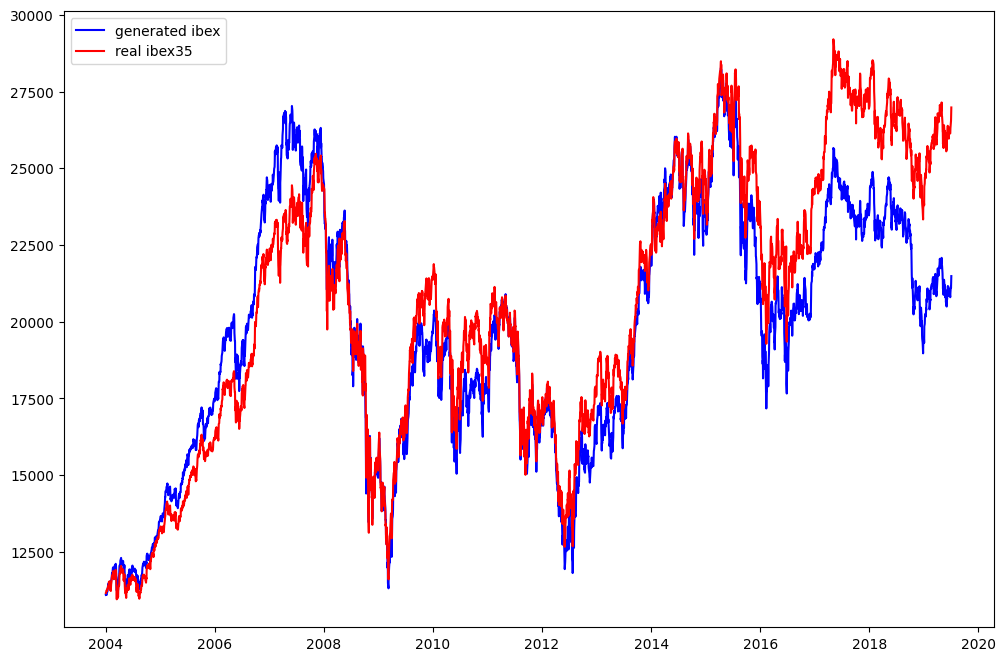

In [11]:
plt.figure(figsize=(12, 8))
plt.plot(ibex_synthetic[0], 'b', label='generated ibex')
plt.plot(ibex35_index['close'], 'r', label='real ibex35')
plt.legend()
plt.show()

La funcion no es perfecta pero acaba aproximando bastante bien al ibex35 real. Debido a esto será la funcion que usaremos para modelar los ibex sintéticos. Importante notar que tiene un componente de drift para simular el ibex con dividendos, lo que hará muy comlicado que podamos batir el indice sintético con nuestro algritmo.

Generamos todos los datos sinteticos:

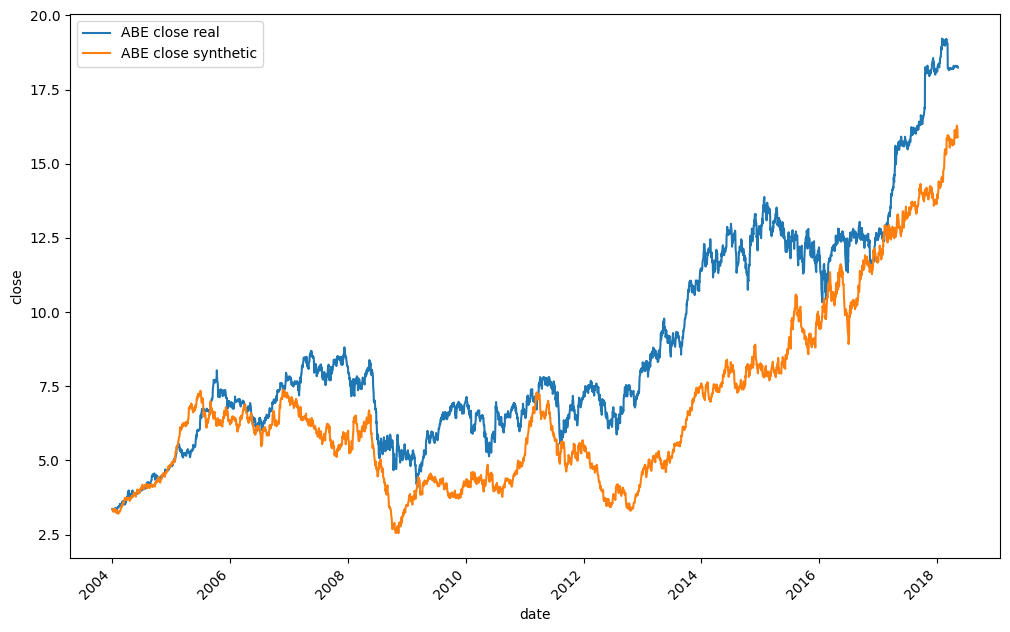

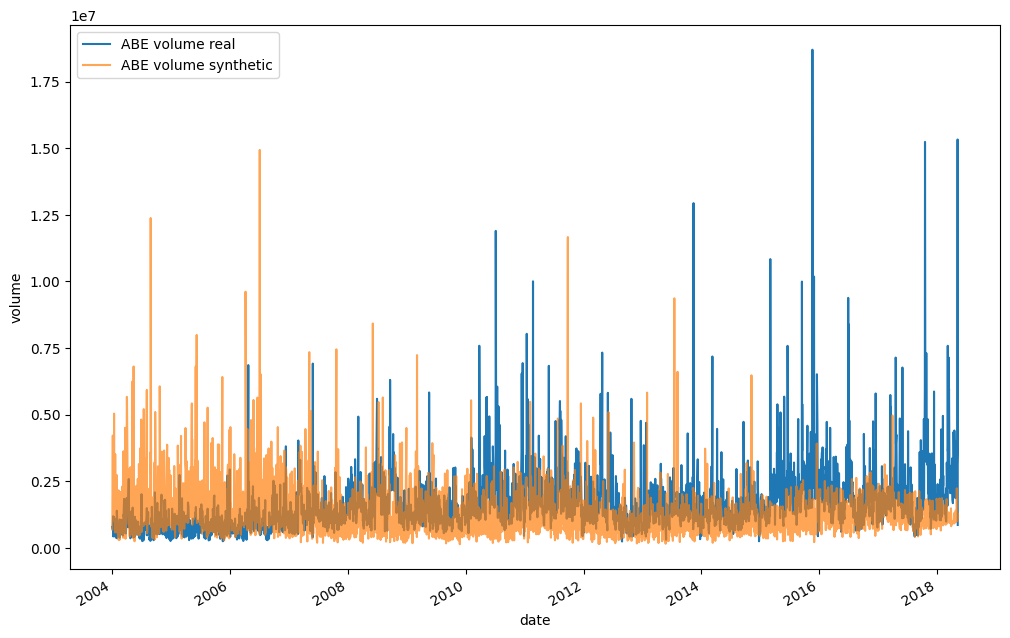

In [12]:
# Generate synthetic data
log_returns = np.log(stocks_ibex_close_data).diff()
log_gap = np.log(stocks_ibex_open_data) - np.log(stocks_ibex_close_data.shift(1))

n_simulations = 500

synthetic_log_returns = generate_synthetic_correlated_data(log_returns, n_simulations)
synthetic_log_gap = generate_synthetic_correlated_data(log_gap, n_simulations)
synthetic_close, synthetic_open = generate_synthetic_stock_data(synthetic_log_returns,
                                                                synthetic_log_gap,
                                                                stocks_ibex_close_data,
                                                                stocks_ibex_open_data)
synthetic_volume = generate_synthetic_volume_df(log_returns,
                                                stocks_ibex_close_data,
                                                stocks_ibex_volume_data,
                                                synthetic_log_returns,
                                                synthetic_close)
synthetic_ibex = calculate_synthetic_ibex35(synthetic_close, synthetic_volume, risk_free_rate=0.015)

for i in range(len(synthetic_close)):
    synthetic_close[i]['IBEX35'] = synthetic_ibex[i] # anadimos el ibex35 sintetico a cada dataframe de close

# plot ABE stock real close and synthetic close
plt.figure(figsize=(12, 8))
stocks_ibex_close_data['ABE'].plot(label='ABE close real')
synthetic_close[1]['ABE'].plot(label='ABE close synthetic')
plt.legend()
plt.ylabel('close')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12, 8))
synthetic_volume_plot = synthetic_volume[1].loc[:, 'ABE'].dropna()
stocks_ibex_volume_data.loc[:, 'ABE'].plot(label='ABE volume real')
synthetic_volume_plot.plot(label='ABE volume synthetic', alpha=0.7)
plt.ylabel('volume')
plt.legend()
plt.show()

Podemos ver en los plots de arriba un ejemplo del stock 'ABE' real contra el sintetico, tanto precios close como volumen.

Veamos más de cerca cómo hemos generado esos precios close y open:

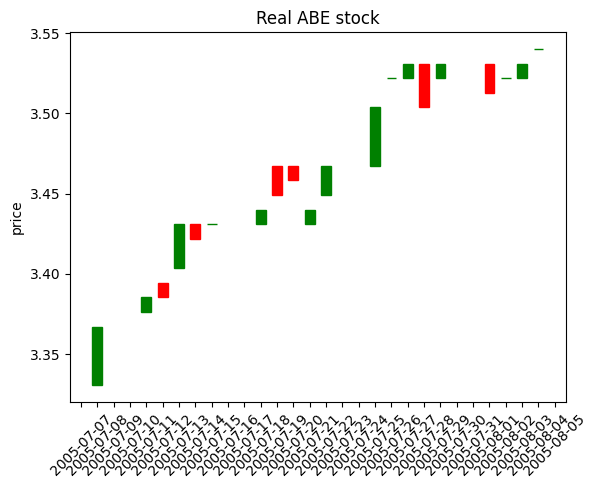

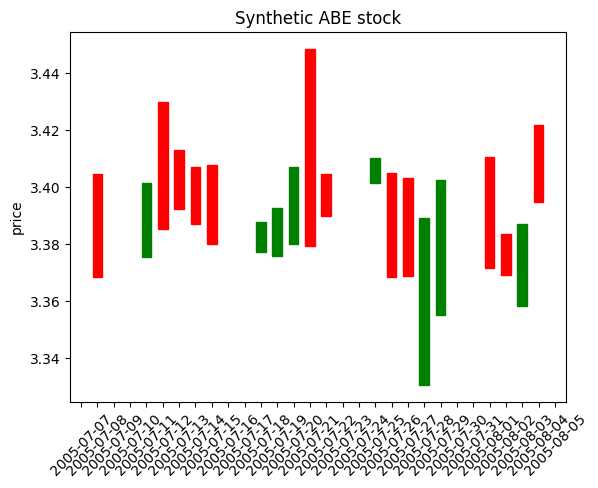

In [13]:
fig, ax = plt.subplots()
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.DayLocator())
ax.set_title('Real ABE stock')
open = stocks_ibex_open_data['ABE'].iloc[20:40]
close = stocks_ibex_close_data['ABE'].iloc[20:40]
candlestick_ohlc(ax, zip(mdates.date2num(stocks_ibex_data['date'].iloc[0:20]), open, close, open, close), width=0.6, colorup='g', colordown='r')
plt.ylabel('price')
plt.xticks(rotation=45)
plt.show()

fig, ax = plt.subplots()
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.DayLocator())
ax.set_title('Synthetic ABE stock')
open = synthetic_open[0]['ABE'].iloc[20:40]
close = synthetic_close[0]['ABE'].iloc[20:40]
candlestick_ohlc(ax, zip(mdates.date2num(stocks_ibex_data['date'].iloc[0:20]), open, close, open, close), width=0.6, colorup='g', colordown='r')
plt.ylabel('price')
plt.xticks(rotation=45)
plt.show()

Parece que los datos sintéticos de apertura y cierre tienen buena pinta y no se ven errores obvios a primera vista

### Generacion de señales con algoritmo dinamico

Aquí lo que vamos a hacer es generar listas de DataFrames en donde guardaremos:

1) synthetic_alfas      - Lista de Dataframes con datos de Alfa de Jensen
2) synthetic_rankings   - Lista de Dataframes con datos de Ranking de Activos
3) synthetic_percentiles- Lista de Dataframes con datos de Percentiles de Alfa de Jensen
4) synthetic_senales    - Lista de Dataframes con datos de Señales OJO, la seña es al día, compra dia siguiente

Funcion para calcular el alfa de Jensen. Esta basada en la funcion del ejercicio 2.7 visto en clase y modificado para calcular el alfa de multiples DFs y teniendo en cuenta las situaciones de entrada y salida de activos del indice. Además se ha comprobado que funciona con los datos del DAX usados en los ejercicios de clase. 

In [14]:
def calcular_alfa_Jensen(stocks_list, eonia):
    """
    Función basada y comparada con la función vista en clase de generar alfas.
    stocks_df = lista de DFs con los precios de los activos
    """
    lista_alfas = []
    for i in range(len(stocks_list)):
        stocks_df = stocks_list[i]
        # Extraer las columnas de activos, DAX y BUND
        n_activos = stocks_df.shape[1] - 1
        activos = stocks_df.iloc[:, :n_activos]
        IBEX35 = stocks_df.iloc[:, n_activos]

        # Calcular la rentabilidad de los activos, renta fija e índice
        rent_activos = np.log(activos / activos.shift(1))
        rent_IBEX35 = np.log(IBEX35 / IBEX35.shift(1))
        rent_EONIA= np.log(eonia / eonia.shift(1))

        # Generar las matrices de datos donde guardaremos los resultados
        varianza_IBEX35 = np.zeros(len(IBEX35))
        cov_act_ind = np.zeros((len(activos)), dtype=np.float16)
        alpha_activos = pd.DataFrame(np.full((len(activos), n_activos), np.nan), index=activos.index, columns=activos.columns)

        # Calcular la varianza móvil del DAX con una ventana de 30 periodos
        varianza_IBEX35[30:] = rent_IBEX35.rolling(window=30).var()[30:]

        # Convertir Series de pandas a arrays de numpy
        rent_EONIA_array = rent_EONIA.values
        rent_IBEX35_array = rent_IBEX35.values

        for i, activo in enumerate(rent_activos.columns):
            ini = rent_activos[activo].first_valid_index()
            end = rent_activos[activo].last_valid_index()

            if ini is not None and end is not None:
                # Convert index labels to positional indices
                ini_pos = rent_activos.index.get_loc(ini)
                end_pos = rent_activos.index.get_loc(end)

                # Compute rolling covariance
                cov_act_ind[ini_pos:end_pos + 1] = (
                    rent_activos[activo].loc[ini:end].rolling(window=30).cov(rent_IBEX35.loc[ini:end])
                )
            
            ini_index = rent_activos.index.get_loc(ini) + 29
            end_index = rent_activos.index.get_loc(end) + 1

            # Sacar la Beta del activo. β=cov(Rc,Rm)/σRm
            beta = cov_act_ind[ini_index:end_index] / varianza_IBEX35[ini_index:end_index]
            # Calcular el Alpha del activo. α=Rc-(Rf+β(Rm-Rf))
            aux = beta * (rent_IBEX35_array[ini_index:end_index] - rent_EONIA_array[ini_index:end_index])
            alpha_activos.iloc[ini_index:end_index, i] = rent_activos.iloc[ini_index:end_index, i].values - (rent_EONIA_array[ini_index:end_index] + aux)

        lista_alfas.append(alpha_activos)

    return lista_alfas

In [15]:
synthetic_alfas = calcular_alfa_Jensen(synthetic_close, eonia['Eonia'])
synthetic_alfas[0].iloc[29:]

c:\Users\danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


ticker,A3TV,ABE,ABG,ABG.P_0,ABG.P_1,ACS,ACX,ACX_0,AENA,AGS,...,SGRE,SGRE_0,TEF,TEM,TL5,TRE,UNF,VIS,VIS_0,ZEL
date,,,,,,,,,,,,,,,,,,,,,
2004-02-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-02-16,NaN,0.002735,NaN,NaN,NaN,-0.008058,NaN,0.019850,NaN,NaN,...,NaN,-0.009653,0.001534,0.001913,NaN,NaN,0.014268,NaN,NaN,-0.023473
2004-02-17,NaN,0.007639,NaN,NaN,NaN,-0.014679,NaN,0.017785,NaN,NaN,...,NaN,-0.008938,-0.001073,0.012969,NaN,NaN,0.010124,NaN,NaN,-0.006059
2004-02-18,NaN,-0.011530,NaN,NaN,NaN,-0.002416,NaN,-0.022588,NaN,NaN,...,NaN,0.008602,0.010855,-0.009437,NaN,NaN,0.004216,NaN,NaN,0.011071
2004-02-19,NaN,-0.003273,NaN,NaN,NaN,-0.009838,NaN,-0.007017,NaN,NaN,...,NaN,-0.020975,-0.012615,0.004112,NaN,NaN,0.003877,NaN,NaN,0.004803
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-28,NaN,NaN,NaN,NaN,NaN,-0.011470,-0.013144,NaN,0.000059,NaN,...,-0.004405,NaN,0.007244,NaN,-0.011194,NaN,NaN,-0.003840,NaN,NaN
2019-07-01,NaN,NaN,NaN,NaN,NaN,-0.015014,0.002457,NaN,-0.018134,NaN,...,-0.023471,NaN,-0.005312,NaN,0.000635,NaN,NaN,-0.010557,NaN,NaN
2019-07-02,NaN,NaN,NaN,NaN,NaN,-0.012826,0.009412,NaN,-0.007376,NaN,...,-0.009734,NaN,0.000632,NaN,-0.013561,NaN,NaN,-0.003175,NaN,NaN


Funcion para ordenar los activos en función del volumen negociado de los ultimos 3 meses para hacer el ranking. Los primeros 3 meses todos tienen el mismo valor de ranking=2

In [16]:
def ranking_3meses(closes, volumes):
    """
    Cada 3 meses se ordenan los activos según su volumen negociado (close*volume).
    Se devuelve una lista de DFs con columnas como activos, 1 el tercio con más volumen, 2 el tercio con menos volumen y 3 el tercio intermedio.
    closes - lista de DFs completo con los precios de cierre
    volumes - lista de DFs completo con los volumenes
    """
    primer_dia = closes[0].index[0]
    ultimo_dia = closes[0].index[-1]
    rangos_3meses = pd.date_range(primer_dia, ultimo_dia, freq='3ME')
    rangos_3meses = rangos_3meses.append(pd.DatetimeIndex([ultimo_dia]))
    stock_nombres = closes[0].columns
    stock_nombres = stock_nombres[stock_nombres != 'IBEX35']
    lista_rankings = []    

    for i in range(len(closes)):
        closes_df = closes[i]
        closes_df = closes_df[stock_nombres]
        volumes_df = volumes[i]
        volumes_df = volumes_df[stock_nombres]

        ranking = pd.DataFrame(index=closes_df.index, columns=closes_df.columns, dtype=int)

        volumen_negociado = closes_df * volumes_df
        
        # los tres primeros meses que no tenemos datos, todos los stocks tendrán asignacion de 2
        ranking.loc[:rangos_3meses[0], :] = 2
        prev_fecha = rangos_3meses[0]
        for fecha in rangos_3meses[1:]:
            # Calcular el volumen negociado de cada activo
            volumen_negociado_sum = volumen_negociado.loc[prev_fecha:fecha].sum()
            
            # Ordenar los activos según el volumen negociado
            volumenes = volumen_negociado_sum.rank(method='first', ascending=False)

            #en el dataframe poner 1 al tercio con más volumen, 2 al tercio con menos volumen y 3 al tercio intermedio
            primer_tercio = stock_nombres[volumenes <= (len(volumenes) / 3)]
            segundo_tercio = stock_nombres[(volumenes > len(volumenes) / 3) & (volumenes <= 2 * len(volumenes) / 3)]
            tercer_tercio = stock_nombres[volumenes > 2 * len(volumenes) / 3]
            ranking.loc[prev_fecha:fecha, primer_tercio] = 1
            ranking.loc[prev_fecha:fecha, segundo_tercio] = 2
            ranking.loc[prev_fecha:fecha, tercer_tercio] = 3

            prev_fecha = fecha
        
        lista_rankings.append(ranking)
    
    return lista_rankings

In [17]:
synthetic_rankings = ranking_3meses(synthetic_close, synthetic_volume)
synthetic_rankings[0]

ticker,A3TV,ABE,ABG,ABG.P_0,ABG.P_1,ACS,ACX,ACX_0,AENA,AGS,...,SGRE,SGRE_0,TEF,TEM,TL5,TRE,UNF,VIS,VIS_0,ZEL
date,,,,,,,,,,,,,,,,,,,,,
2004-01-02,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
2004-01-05,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
2004-01-07,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
2004-01-08,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
2004-01-09,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-28,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,1.0,2.0,...,1.0,3.0,1.0,3.0,2.0,1.0,3.0,2.0,3.0,3.0
2019-07-01,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,1.0,2.0,...,1.0,3.0,1.0,3.0,2.0,1.0,3.0,2.0,3.0,3.0
2019-07-02,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,1.0,2.0,...,1.0,3.0,1.0,3.0,2.0,1.0,3.0,2.0,3.0,3.0


vamos a crear ahora la función para calcular si los alfas estan dentro del percentil inferior o superior

In [18]:
def calcular_percentiles_alfas(alfas_jensen, percentil_superior=0.85, percentil_inferior=0.15):
    """
    alfas_jensen = lista de DFs con los alfas de Jensen
    devolvemos una lista de DFs en donde si el alfa del activo en el día está en el percentil > 85 ponemos 1, 
    y si está en el percentil < 15 ponemos -1 y 0 en otro caso. 
    Los percentiles se calculan con todos los activos diariamente.
    """
    lista_percentiles = []  
    
    for alfas in alfas_jensen:
        # Excluir la columna 'IBEX35' si existe
        alfas_sin_ibex = alfas.drop(columns=['IBEX35'], errors='ignore')
        
        percentiles_dia = alfas_sin_ibex.rank(pct=True, axis=1)

        # Asignar valores según rank
        percentiles = pd.DataFrame(
            np.select([percentiles_dia > percentil_superior, percentiles_dia < percentil_inferior], [1, -1], default=0),
            index=alfas.index,
            columns=alfas_sin_ibex.columns
        )

        lista_percentiles.append(percentiles)
    
    return lista_percentiles

In [19]:
synthetic_percentiles = calcular_percentiles_alfas(synthetic_alfas)
synthetic_percentiles[0].iloc[29:]

ticker,A3TV,ABE,ABG,ABG.P_0,ABG.P_1,ACS,ACX,ACX_0,AENA,AGS,...,SGRE,SGRE_0,TEF,TEM,TL5,TRE,UNF,VIS,VIS_0,ZEL
date,,,,,,,,,,,,,,,,,,,,,
2004-02-13,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2004-02-16,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,-1
2004-02-17,0,0,0,0,0,-1,0,1,0,0,...,0,0,0,1,0,0,1,0,0,0
2004-02-18,0,-1,0,0,0,0,0,-1,0,0,...,0,0,1,0,0,0,0,0,0,1
2004-02-19,0,0,0,0,0,0,0,0,0,0,...,0,-1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-28,0,0,0,0,0,-1,-1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-07-01,0,0,0,0,0,-1,0,0,-1,0,...,-1,0,0,0,0,0,0,0,0,0
2019-07-02,0,0,0,0,0,-1,1,0,0,0,...,-1,0,0,0,-1,0,0,0,0,0


Creamos ahora una funcion para calcular el dataframe que guardará las señales. -1 sera venta al día siguiente, 1 sera compra al día siguiente

In [20]:
def generar_senales(percentiles):
    """
    Genera señales basadas en los cambios de los percentiles de los alfas de Jensen.
    percentiles = lista de DFs con los percentiles de los alfas de Jensen
    genera Lista de DataFrames con las señales generadas.
    """
    senales_res = []
    
    for df in percentiles:
        senales_df = pd.DataFrame(0, index=df.index, columns=df.columns, dtype=int)

        df_anterior = df.shift(1)

        # Señal : si el valor actual es -1 y el anterior no lo era o 1 y anterior no lo era
        senales_df.iloc[1:] = np.where((df.iloc[1:] == -1) & (df_anterior.iloc[1:] != -1), 1,
                                       np.where((df.iloc[1:] == 1) & (df_anterior.iloc[1:] != 1), -1, 0))

        senales_res.append(senales_df)

    return senales_res

In [21]:
synthetic_senales = generar_senales(synthetic_percentiles)
synthetic_senales[0].iloc[29:]

ticker,A3TV,ABE,ABG,ABG.P_0,ABG.P_1,ACS,ACX,ACX_0,AENA,AGS,...,SGRE,SGRE_0,TEF,TEM,TL5,TRE,UNF,VIS,VIS_0,ZEL
date,,,,,,,,,,,,,,,,,,,,,
2004-02-13,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2004-02-16,0,0,0,0,0,0,0,-1,0,0,...,0,0,0,0,0,0,-1,0,0,1
2004-02-17,0,0,0,0,0,1,0,0,0,0,...,0,0,0,-1,0,0,0,0,0,0
2004-02-18,0,1,0,0,0,0,0,1,0,0,...,0,0,-1,0,0,0,0,0,0,-1
2004-02-19,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-28,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-07-01,0,0,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
2019-07-02,0,0,0,0,0,0,-1,0,0,0,...,0,0,0,0,1,0,0,0,0,0


#### Algoritmo de inversión

Ahora escribiremos la funcion que, recibidos los dataframes, ejecutará el algoritmo de inversión y devolvera la cartera diaria en forma de un dataframe donde se undicará cuánto se tiene comprado de cada activo y cuánto se tiene en cash/liquido:

In [22]:
"""
Tenemos lo siguiente
1) synthetic_close      - Lista de Dataframes con datos de Cierre con IBEX35
2) synthetic_open       - Lista de Dataframes con datos de Apertura
3) synthetic_volume     - Lista de Dataframes con datos de Volumen
4) synthetic_alfas      - Lista de Dataframes con datos de Alfa de Jensen
5) synthetic_rankings   - Lista de Dataframes con datos de Ranking de Activos
6) synthetic_percentiles- Lista de Dataframes con datos de Percentiles de Alfa de Jensen
7) synthetic_senales    - Lista de Dataframes con datos de Señales OJO, la seña es al día, compra dia siguiente

Todos los DF empiezan y acaban en la misma fecha y, exceto el open y close que tienen el IBEX35 de extra, 
el resto de DFs tienen los mismos activos.
"""

def ejecutar_orden(precio, volumen_max, comision, comision_minima, limite_asignacion, compraventa):
    """
    parametros
    precio: precio de la accion
    volumen_max: volumen maximo en numero de acciones
    comision: comision variable
    comision_minima: comision minima
    limite_asignacion: limite de asignacion en nº opciones/asignación objetivo
    compraventa: 1 si es compra, 0 si es venta

    Devuelve capital y numero de opciones compradas/vendidas que mas se acerque al limite de asignación pero sin pasarse.
    """
    n_acciones = 0
    capital = 0

    if volumen_max > limite_asignacion:
        n_acciones = limite_asignacion
    else:
        n_acciones = volumen_max
    
    capital = n_acciones * precio
    comision_total = max(comision_minima, comision * capital)

    if compraventa == 1:
        capital += comision_total
    else:
        capital -= comision_total
    
    return capital, n_acciones

# algoritmo de inversion
def ejecutar_algoritmo(synthetic_senales, synthetic_close, synthetic_open, synthetic_volume, synthetic_rankings, capital_inicial = 10_000_000, seguir_comprando = False):
    """
    Ejecuta el algoritmo de inversión con las señales generadas.

    Parámetros:
    synthetic_senales = Lista de DataFrames con las señales generadas.

    Retorna:
    Lista de DataFrames con los resultados de la ejecución del algoritmo.
    """
    comision_fija = 8
    comision_variable = 0.0008

    # Inicializar lista
    portfolio_lista = []
    cash_lista = []

    for i in range(len(synthetic_senales)):
        senalesDf = synthetic_senales[i]
        closeDf = synthetic_close[i]
        closeDf = closeDf.loc[:, closeDf.columns != 'IBEX35']
        openDf = synthetic_open[i]
        openDf = openDf.loc[:, openDf.columns != 'IBEX35']
        volumeDf = synthetic_volume[i]
        rankingsDf = synthetic_rankings[i]
        count_sell_signals = pd.Series(0, index=senalesDf.columns, dtype=int)

        capital_disponible = capital_inicial
        patrimonio = capital_inicial

        resultado = pd.DataFrame(0, index=senalesDf.index, columns=senalesDf.columns, dtype=int)
        cash = pd.DataFrame(0, index=senalesDf.index, columns=['capital_libre'], dtype=float)
        cash.loc[senalesDf.index[0]] = capital_inicial

        # ir dia a dia calculando si hay que comprar o vencer (mirando el dia de atras)
        for dia in senalesDf.index[1:]:
            dia_anterior = senalesDf.index[senalesDf.index.get_loc(dia) - 1]
            senal = senalesDf.loc[dia_anterior]
            close = closeDf.loc[dia]
            open = openDf.loc[dia]
            volume = volumeDf.loc[dia]
            ranking = rankingsDf.loc[dia]

            patrimonio = capital_disponible + sum(resultado.loc[dia_anterior] * closeDf.loc[dia_anterior].fillna(0))

            # copiar resultado del dia anterior a hoy
            resultado.loc[dia] = resultado.loc[dia_anterior]

            # comprobar si hay activos que han salido del indice(close == NAN) en los que estabamos comprados. en ese caso vender todo
            for activo in resultado.columns[resultado.loc[dia] != 0]:
                if np.isnan(close[activo]):
                    capital, n_acciones = ejecutar_orden(closeDf.loc[dia_anterior, activo],
                                                        1e12,  
                                                        comision_variable,
                                                        comision_fija,
                                                        resultado.loc[dia_anterior, activo],
                                                        0)
                    capital_disponible += capital
                    resultado.loc[dia, activo] -= n_acciones

            # comprobar si para ventas (-1 en senal del dia anterior) de todos los activos hay algun activo comprado que se pueda vender
            for activo in senal.index[senal == -1]:
                count_sell_signals[activo] += 1
                if resultado.loc[dia_anterior, activo] > 0 and volume[activo] > 0:
                    volumen_max = int(0.3 * volume[activo])
                    capital, n_acciones = ejecutar_orden(open[activo],
                                                        volumen_max,
                                                        comision_variable,
                                                        comision_fija,
                                                        resultado.loc[dia_anterior, activo],
                                                        0)
                    capital_disponible += capital
                    resultado.loc[dia, activo] -= n_acciones

                    if resultado.loc[dia, activo] > 0:
                        senalesDf.loc[dia, activo] = -1 #para seguir vendiendo al dia siguiente
            
            # comprobar si para compras (1 en senal del dia anterior) de todos los activos hay algun activo que se pueda comprar
            for activo in count_sell_signals[senal == 1].sort_values(ascending=False).index: # TODO, looks good but check
                count_sell_signals[activo] -= 1
                if capital_disponible > 0 and volume[activo] > 0:
                    volumen_max = int(0.4 * volume[activo])
                    # si rankin 1 entonces 10% patrimonio, si 2 entonces 5% y si 3 entonces 2%
                    limite_asignacion = 0
                    if ranking[activo] == 1:
                        limite_asignacion = 0.1 * patrimonio
                    elif ranking[activo] == 2:
                        limite_asignacion = 0.05 * patrimonio
                    else:
                        limite_asignacion = 0.02 * patrimonio
                    
                    if limite_asignacion < capital_disponible:
                        limite_asignacion_n_stock = int(limite_asignacion / close[activo])
                    else:
                        limite_asignacion_n_stock = int(capital_disponible / close[activo])
                    
                    limite_asignacion_n_stock = int(limite_asignacion_n_stock - resultado.loc[dia_anterior, activo])

                    if limite_asignacion_n_stock <= 0:
                        continue

                    capital, n_acciones = ejecutar_orden(close[activo],
                                                        volumen_max,
                                                        comision_variable,
                                                        comision_fija,
                                                        limite_asignacion_n_stock,
                                                        1)
                    
                    if seguir_comprando and n_acciones < limite_asignacion_n_stock:
                        senalesDf.loc[dia, activo] = 1 # seguir comprando al día siguiente

                    if n_acciones > 0:
                        count_sell_signals[activo] -= 2 # esto es para que no se compre siempre los mismos y
                                                        # se de prioridad a otros

                    # en caso que el capital disponible se volviera negativo
                    while (capital_disponible - capital) < 0:
                        limite_asignacion_n_stock -= 1
                        if limite_asignacion_n_stock <= 0:
                            capital = 0
                            n_acciones = 0
                            break
                        capital, n_acciones = ejecutar_orden(close[activo],
                                    volumen_max,
                                    comision_variable,
                                    comision_fija,
                                    limite_asignacion_n_stock,
                                    1) 
                    
                    capital_disponible -= capital
                    resultado.loc[dia, activo] += n_acciones
            
            cash.loc[dia] = capital_disponible
            
        portfolio_lista.append(resultado)
        cash_lista.append(cash)

    return portfolio_lista, cash_lista

In [23]:
synthetic_portfolio, synthetic_cash = ejecutar_algoritmo(synthetic_senales, synthetic_close, synthetic_open, synthetic_volume, synthetic_rankings)
synthetic_portfolio[0].iloc[29:]

ticker,A3TV,ABE,ABG,ABG.P_0,ABG.P_1,ACS,ACX,ACX_0,AENA,AGS,...,SGRE,SGRE_0,TEF,TEM,TL5,TRE,UNF,VIS,VIS_0,ZEL
date,,,,,,,,,,,,,,,,,,,,,
2004-02-13,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2004-02-16,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2004-02-17,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,117806
2004-02-18,0,0,0,0,0,162451,0,0,0,0,...,0,0,0,0,0,0,0,0,0,117806
2004-02-19,0,132925,0,0,0,162451,0,176721,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-28,0,0,0,0,0,0,141894,0,5894,0,...,153451,0,142296,0,2,0,0,19341,0,0
2019-07-01,0,0,0,0,0,0,141894,0,5894,0,...,153451,0,142296,0,2,0,0,19341,0,0
2019-07-02,0,0,0,0,0,0,141894,0,5894,0,...,153451,0,142296,0,2,0,0,19341,0,0


In [24]:
synthetic_cash[0]

,capital_libre
date,
2004-01-02,1.000000e+07
2004-01-05,1.000000e+07
2004-01-07,1.000000e+07
2004-01-08,1.000000e+07
2004-01-09,1.000000e+07
...,...
2019-06-28,1.114722e+06
2019-07-01,1.698406e-01
2019-07-02,1.698406e-01


Calulamos ahora el patrimonio total (valor de los activos más el cash)

In [25]:
# calcular patrimonio cash + activos
synthetic_patrimonio = []
for i in range(len(synthetic_portfolio)):
    synthetic_patrimonio.append(pd.DataFrame(index=synthetic_portfolio[0].index, columns=['Patrimonio', 'IBEX35']))
    patrimonio = (synthetic_portfolio[i] * synthetic_close[i]).fillna(0).sum(axis=1) + synthetic_cash[i]['capital_libre']
    synthetic_patrimonio[i]['Patrimonio'] = patrimonio
    synthetic_patrimonio[i]['IBEX35'] = synthetic_close[i]['IBEX35'] * 10_000_000/synthetic_close[i]['IBEX35'].iloc[0]

# calcular alfas para generar gráfico
algo_alpha = calcular_alfa_Jensen(synthetic_patrimonio,  eonia['Eonia'])

mean_algo_alpha = []
for i in range(len(synthetic_patrimonio)):
    mean_algo_alpha.append(algo_alpha[i].mean()['Patrimonio'])

c:\Users\danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Veamos un poco más gráficamente estos resultads:

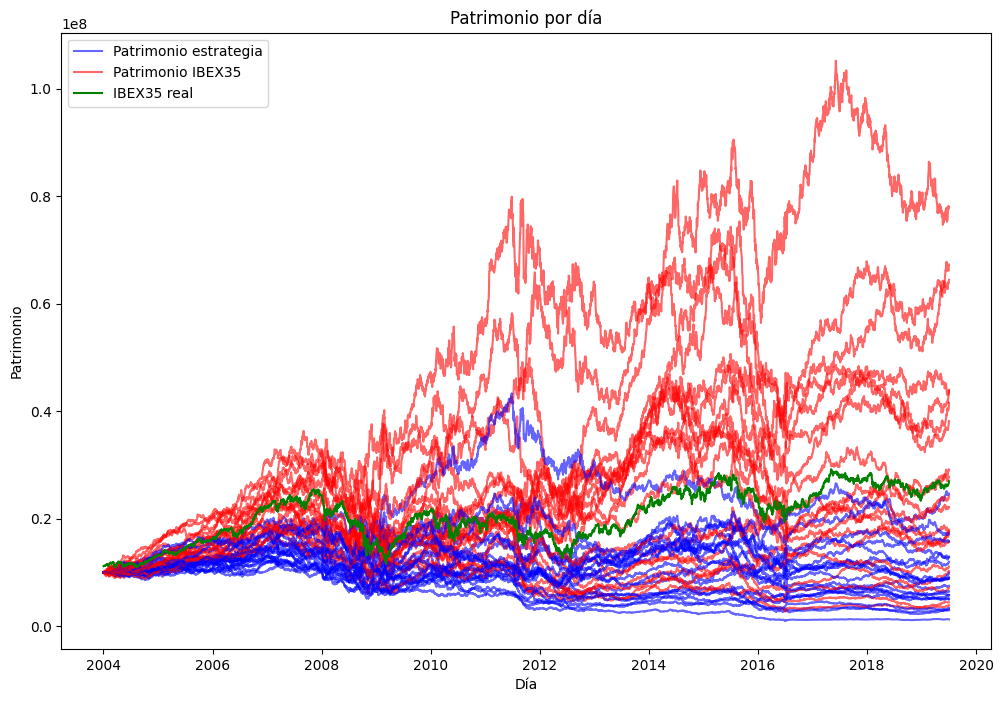

In [26]:
# plot patrimonio DF Patrimonio and IBEX35
fig, ax = plt.subplots(figsize=(12, 8))
for i in range(20):
    if i == 0:
        ax.plot(synthetic_patrimonio[i]['Patrimonio'], 'b', label='Patrimonio estrategia', alpha = 0.6)
        ax.plot(synthetic_patrimonio[i]['IBEX35'], 'r', label='Patrimonio IBEX35', alpha = 0.6)
    else:
        ax.plot(synthetic_patrimonio[i]['Patrimonio'], 'b', alpha = 0.6)
        ax.plot(synthetic_patrimonio[i]['IBEX35'], 'r', alpha = 0.6) 

    # corr = synthetic_patrimonio[i]['Patrimonio'].corr(synthetic_patrimonio[i]['IBEX35'])
    # print(f"Correlation between Patrimonio and IBEX35: {corr}")

ax.plot(ibex35_index['close']*1000, 'g', label='IBEX35 real')
ax.set_xlabel('Día')
ax.set_ylabel('Patrimonio')
ax.set_title('Patrimonio por día')
ax.legend()  # Show legend if multiple simulations exist
plt.show()

#### Graficos del resultado del algoritmo

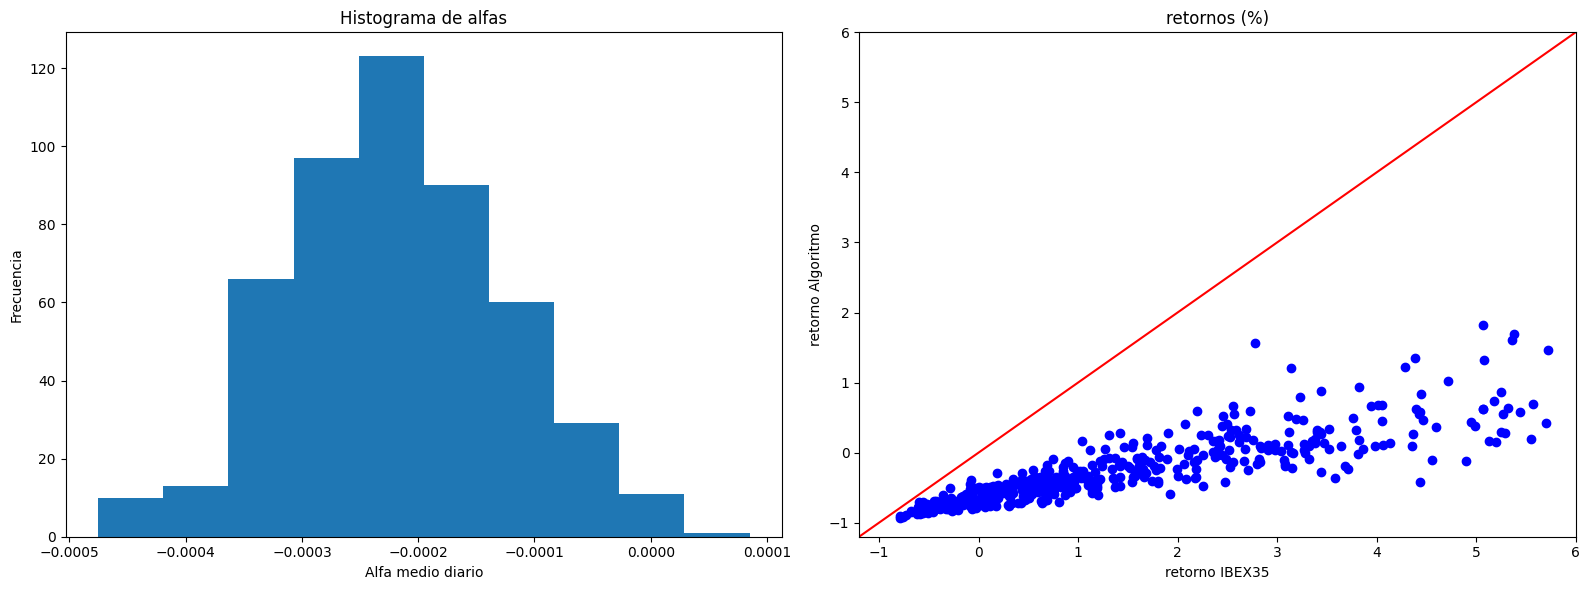

In [27]:
# plot pctg return
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Histograma de alfas (izquierda)
axs[0].hist(mean_algo_alpha, bins=10)
axs[0].set_xlabel('Alfa medio diario')
axs[0].set_ylabel('Frecuencia')
axs[0].set_title('Histograma de alfas')

# Patrimonio final (derecha)
for i in range(len(synthetic_patrimonio)):
    pct_return_algo = (synthetic_patrimonio[i].iloc[-1, 0] - synthetic_patrimonio[i].iloc[0, 0]) / synthetic_patrimonio[i].iloc[0, 0]
    pct_return_ibex35 = (synthetic_patrimonio[i].iloc[-1, 1] - synthetic_patrimonio[i].iloc[0, 1]) / synthetic_patrimonio[i].iloc[0, 1]
    axs[1].plot(pct_return_ibex35, pct_return_algo, 'bo')

axs[1].plot([-1.2, 6], [-1.2, 6], 'r')
axs[1].set_xlabel('retorno IBEX35')
axs[1].set_ylabel('retorno Algoritmo')
axs[1].set_title('retornos (%)')
axs[1].set_xlim([-1.2, 6])
axs[1].set_ylim([-1.2, 6])

plt.tight_layout()
plt.show()

#### Conclusiones

En los gráficos se observa claramente cómo los resultados de nuestro algoritmo son inferiores al benchmark, los datos sintéticos del ibex. Lo que en parte tiene sentido si tenemos en cuenta que, al final, son datos generados a partir de una normal transformada para representar correlaciones en donde muy probablemente no se refleje las propiedades de regresión a la media necesarias para que el algoritmo funcione y que sí podrían encontrarse en los datos reales. A esto hay que sumare la desventaja de que los ibex son "con dividendos" (tienen un drift ligeramente positivo) y que las operaciones tienen comisiones.

**Bloque 2**

Calcula ahora el resultado del algoritmo usando la serie histórica. Calcula los gráficos anteriores con 100 periodos aleatorios de 1 año, 100 de 3 años y 100 de 5 años. 

    Calcula las siguientes métricas para el algoritmo (usando toda la serie histórica, no periodos de 1, 3 o 5 años):

        - Evolución relativa de la estrategia con respecto al benchmark (con y sin dividendos).
        - Duración media del trade
        - Porcentaje de trades en ganancias/pérdidas
        - Rentabilidad media de los trades positivos/negativos
        - Drawdown y tiempo bajo Agua
        - Rendimiento anualizado
        - Ratio de Sharpe
        - Active_return 
        - Information Ratio


In [28]:
# calculamos valores reales
stocks_ibex_close_data['IBEX35'] = ibex35_index['close']

real_alpha = calcular_alfa_Jensen([stocks_ibex_close_data],  eonia['Eonia'])
real_rankings = ranking_3meses([stocks_ibex_close_data], [stocks_ibex_volume_data])
real_percentiles = calcular_percentiles_alfas(real_alpha)
real_senales  = generar_senales(real_percentiles)
real_cartera, real_cash = ejecutar_algoritmo(real_senales,
                                            [stocks_ibex_close_data],
                                            [stocks_ibex_open_data],
                                            [stocks_ibex_volume_data],
                                            real_rankings)

c:\Users\danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [29]:
def plot_patrimonio(real_cartera, stocks_ibex_close_data, real_cash, ibex35_index, ini_cap = 10_000_000):
    fig, ax = plt.subplots(figsize=(12, 8))
    patrimonio = (real_cartera[0] * stocks_ibex_close_data).fillna(0).sum(axis=1) + real_cash[0]['capital_libre']
    ax.plot(patrimonio, 'b', label='cartera algoritmo real')
    patrimonio_ibex = ibex35_index['close'] * ini_cap / ibex35_index['close'].iloc[0]
    ax.plot(patrimonio_ibex, 'r', label='IBEX35 div')
    ax.set_xlabel('Día')
    ax.set_ylabel('Patrimonio')
    ax.set_title(f'Patrimonio por día con {int(ini_cap/1_000_000)} millones de €')
    ax.legend()
    plt.show()

Ejecutemos el algoritmo con datos reales:

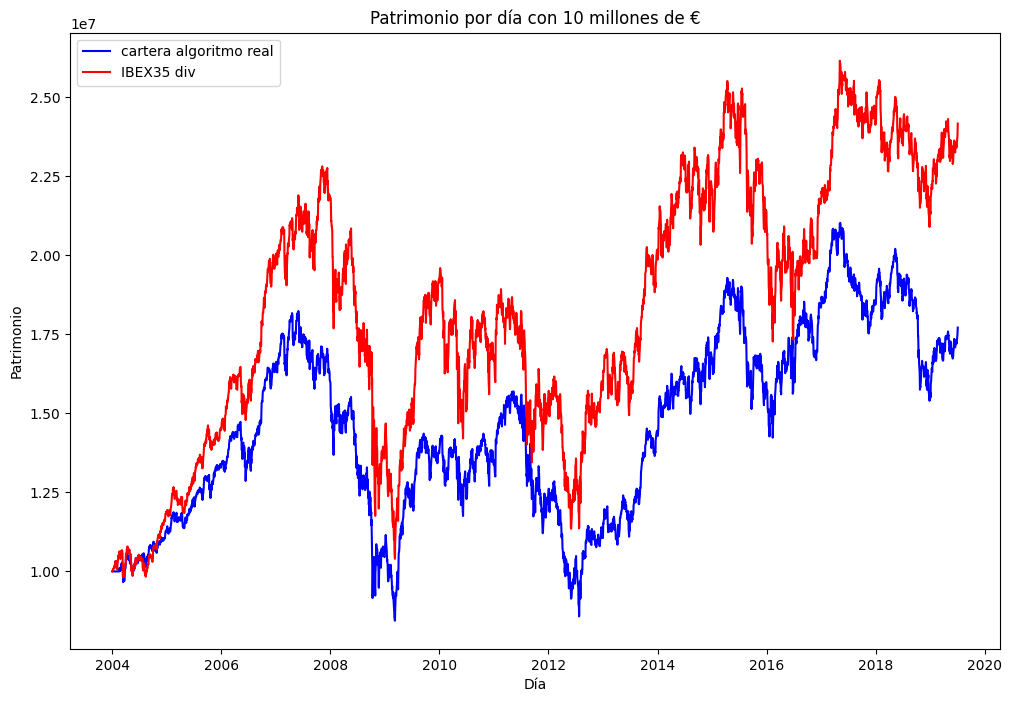

In [30]:
# Plot patrimonio
plot_patrimonio(real_cartera, stocks_ibex_close_data, real_cash, ibex35_index)

Podemos ver que el algoritmo rinde peor que el ibex y se mantiene por debajo de el a lo largo de todo el periodo. Además, tampoco parece que haga un gran trabajo a la hora de tratar de reducir el drawdown con respecto a los drawdowns del ibex. Por lo que parece que acaba obteniendo una rentabilidad inferior y una volatilidad que parece muy parecida a la del ibex con dividendos.

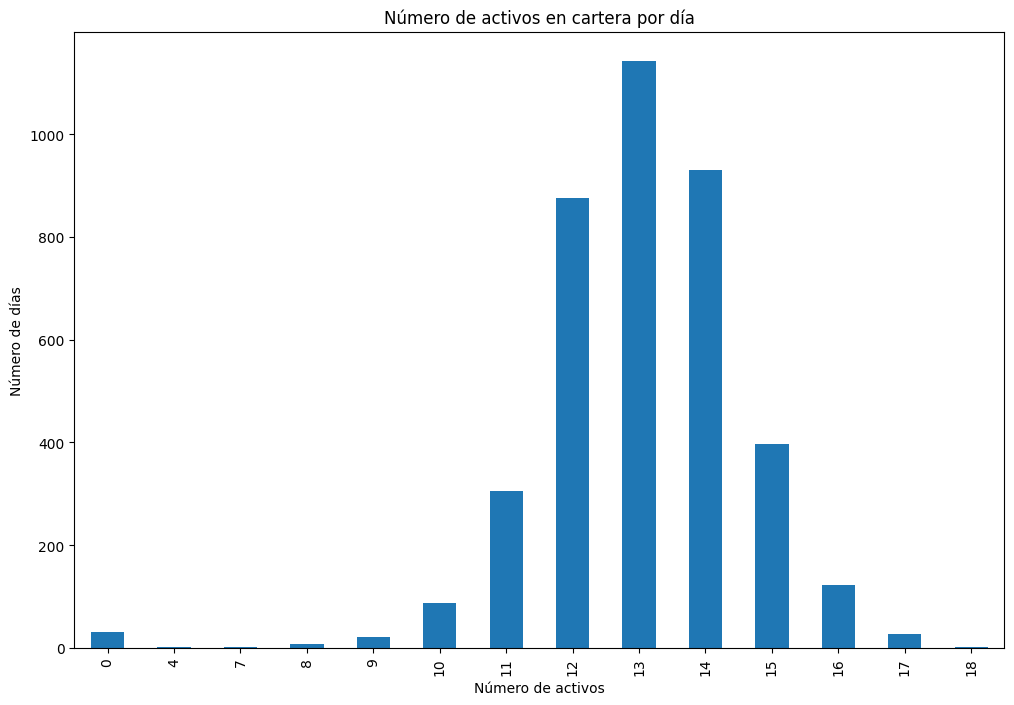

In [31]:
# count how many greater than 0 are in every row of dataframe cartera real and print it
real_cartera[0].gt(0).sum(axis=1).value_counts().sort_index().plot(kind='bar', figsize=(12, 8))
plt.title('Número de activos en cartera por día')
plt.xlabel('Número de activos')
plt.ylabel('Número de días')
plt.show()

Podemos observar que la media de activos en los que se esta invertido es normalmente 13

Veamos las métricas:

In [32]:
def calculate_metrics(real_cartera, stocks_ibex_close_data, real_cash, ibex35_index):
    patrimonio = (real_cartera[0] * stocks_ibex_close_data).fillna(0).sum(axis=1) + real_cash[0]['capital_libre']
    returns = patrimonio.pct_change().dropna()

    trade_durations = (real_cartera[0] != 0).astype(int).diff().abs()
    duracion_media_trade = trade_durations.sum().mean()

    trades = patrimonio.diff().dropna()
    porcentaje_ganancia_perdida = (trades > 0).sum() / len(trades)

    rentabilidad_media_positiva = trades[trades > 0].mean()
    rentabilidad_media_negativa = trades[trades < 0].mean()

    running_max = patrimonio.cummax()
    drawdown = (patrimonio - running_max) / running_max
    max_drawdown = drawdown.min()
    tiempo_bajo_agua = (drawdown < 0).sum()

    rendimiento_anualizado = (1 + returns.mean())**252 - 1

    sharpe_ratio = returns.mean() / returns.std() * np.sqrt(252)

    ibex_returns = ibex35_index['close'].pct_change().dropna()
    active_return = returns.mean() - ibex_returns.mean()

    tracking_error = (returns - ibex_returns).std()

    information_ratio = active_return / tracking_error if tracking_error != 0 else np.nan
    
    results = {
        "Duración media de trade (días)": duracion_media_trade,
        "Porcentaje de trades con ganancia (%)": porcentaje_ganancia_perdida * 100,
        "Rentabilidad media positiva (€)": rentabilidad_media_positiva,
        "Rentabilidad media negativa (€)": rentabilidad_media_negativa,
        "Máximo drawdown (%)": max_drawdown * 100,
        "Tiempo bajo agua (días)": tiempo_bajo_agua,
        "Rendimiento anualizado (%)": rendimiento_anualizado * 100,
        "Sharpe ratio": sharpe_ratio,
        "Active return (%)": active_return * 100,
        "Information ratio": information_ratio
    }
    return results

res = calculate_metrics(real_cartera, stocks_ibex_close_data, real_cash, ibex35_index)
for key, value in res.items():
    print(f"{key}: {value}")


Duración media de trade (días): 218.43037974683546
Porcentaje de trades con ganancia (%): 52.074898785425106
Rentabilidad media positiva (€): 114911.1164162378
Rentabilidad media negativa (€): -122731.42224270245
Máximo drawdown (%): -53.73560393030631
Tiempo bajo agua (días): 3720
Rendimiento anualizado (%): 5.621530773847416
Sharpe ratio: 0.2863127910325815
Active return (%): -0.010441108052521474
Information ratio: -0.017498022456924327


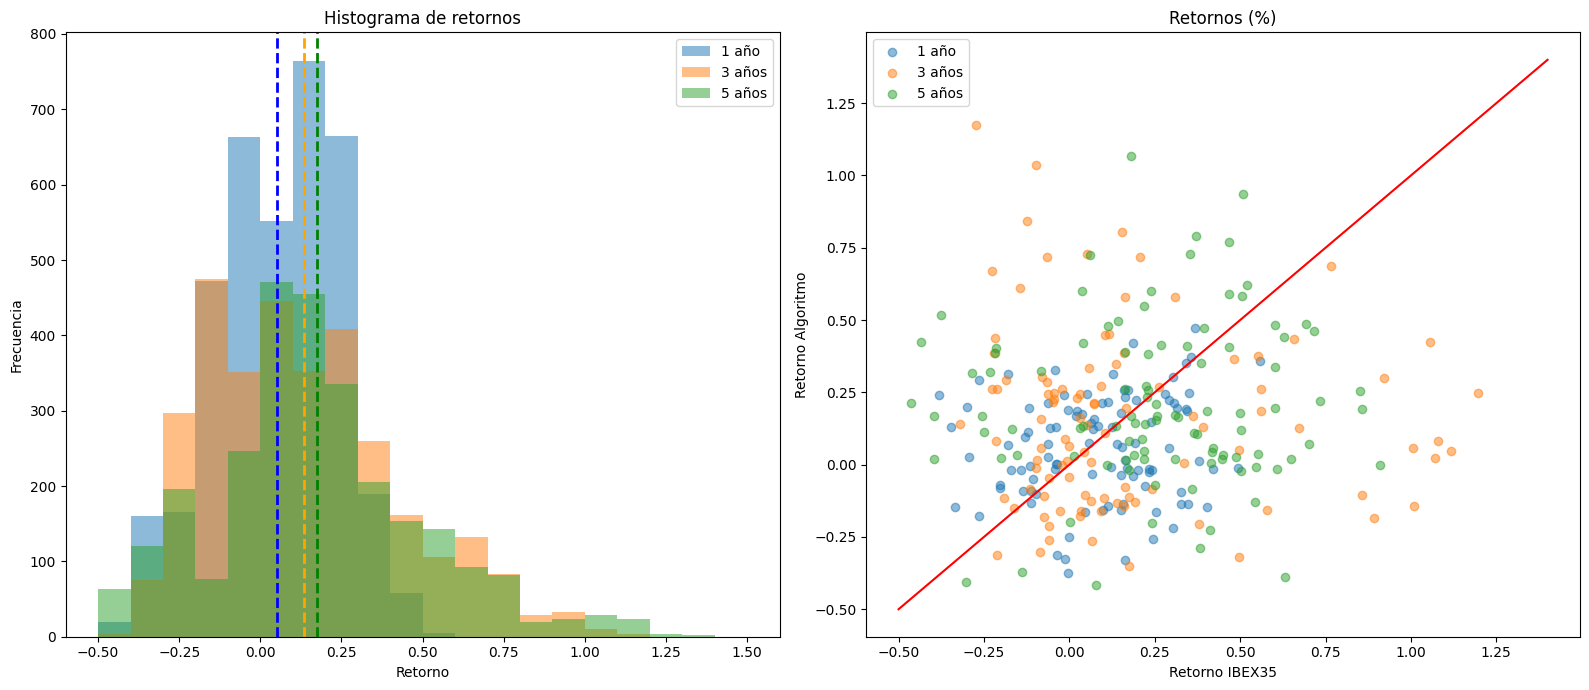

In [33]:
# Cálculo de periodos de 1-3-5 años del rolling del patrimonio y del IBEX
patrimonio_algo_real = (real_cartera[0] * stocks_ibex_close_data).fillna(0).sum(axis=1) + real_cash[0]['capital_libre']
returns_algo_1 = (patrimonio_algo_real[242:].values - patrimonio_algo_real[:-242].values) / patrimonio_algo_real[:-242].values
returns_algo_3 = (patrimonio_algo_real[726:].values - patrimonio_algo_real[:-726].values) / patrimonio_algo_real[:-726].values
returns_algo_5 = (patrimonio_algo_real[1210:].values - patrimonio_algo_real[:-1210].values) / patrimonio_algo_real[:-1210].values
returns_ibex_1 = (ibex35_index['close'][242:].values - ibex35_index['close'][:-242].values) / ibex35_index['close'][:-242].values
returns_ibex_3 = (ibex35_index['close'][726:].values - ibex35_index['close'][:-726].values) / ibex35_index['close'][:-726].values
returns_ibex_5 = (ibex35_index['close'][1210:].values - ibex35_index['close'][:-1210].values) / ibex35_index['close'][:-1210].values

# plot histograms of returns_algo 1 3 5 and another scatter graph
fig, axs = plt.subplots(1, 2, figsize=(16, 7))
axs[0].hist(returns_algo_1, bins=20, alpha=0.5, label='1 año', range=(-0.5, 1.5))
axs[0].hist(returns_algo_3, bins=20, alpha=0.5, label='3 años', range=(-0.5, 1.5))
axs[0].hist(returns_algo_5, bins=20, alpha=0.5, label='5 años', range=(-0.5, 1.5))
axs[0].set_xlabel('Retorno')
axs[0].set_ylabel('Frecuencia')
axs[0].set_title('Histograma de retornos')
axs[0].legend()
axs[0].axvline(np.mean(returns_algo_1), color='blue', linestyle='dashed', linewidth=2)
axs[0].axvline(np.mean(returns_algo_3), color='orange', linestyle='dashed', linewidth=2)
axs[0].axvline(np.mean(returns_algo_5), color='green', linestyle='dashed', linewidth=2)

returns_ibex_1_random_100 = np.random.choice(returns_ibex_1, 100)
returns_ibex_3_random_100 = np.random.choice(returns_ibex_3, 100)
returns_ibex_5_random_100 = np.random.choice(returns_ibex_5, 100)
returns_algo_5_random_100 = np.random.choice(returns_algo_5, 100)
returns_algo_3_random_100 = np.random.choice(returns_algo_3, 100)
returns_algo_1_random_100 = np.random.choice(returns_algo_1, 100)

axs[1].scatter(returns_ibex_1_random_100, returns_algo_1_random_100, label='1 año', alpha=0.5)
axs[1].scatter(returns_ibex_3_random_100, returns_algo_3_random_100, label='3 años', alpha=0.5)
axs[1].scatter(returns_ibex_5_random_100, returns_algo_5_random_100, label='5 años', alpha=0.5)
axs[1].plot([-0.5, 1.4], [-0.5, 1.4], 'r')
axs[1].set_xlabel('Retorno IBEX35')
axs[1].set_ylabel('Retorno Algoritmo')
axs[1].set_title('Retornos (%)')
axs[1].legend()
plt.tight_layout()
plt.show()

#### Comentario de resultados



En los gráficos no se observa que el algoritmo de mejores resultados que el benchmark. En los histogramas las medias estan muy cercanas a 0 y en el scatter plot los puntos se distribuyen de forma dispersa sin una forma clara.

**Bloque 3**

Varía el capital bajo gestión a 30, 100 y 1.000 millones bajo gestión. ¿Cómo afecta este cambio al proceso de asignación de capital?, ¿cómo afecta al resultado del algoritmo?

Comenta, ampliamente, los resultados y las implicaciones de variar el capital en el algoritmo dinámico aplicado al Ibex.

In [34]:
real_cartera_30, real_cash_30 = ejecutar_algoritmo(real_senales,
                                            [stocks_ibex_close_data],
                                            [stocks_ibex_open_data],
                                            [stocks_ibex_volume_data],
                                            real_rankings,
                                            30_000_000)

real_cartera_100, real_cash_100 = ejecutar_algoritmo(real_senales,
                                            [stocks_ibex_close_data],
                                            [stocks_ibex_open_data],
                                            [stocks_ibex_volume_data],
                                            real_rankings,
                                            100_000_000)

real_cartera_1000, real_cash_1000 = ejecutar_algoritmo(real_senales,
                                            [stocks_ibex_close_data],
                                            [stocks_ibex_open_data],
                                            [stocks_ibex_volume_data],
                                            real_rankings,
                                            1_000_000_000)

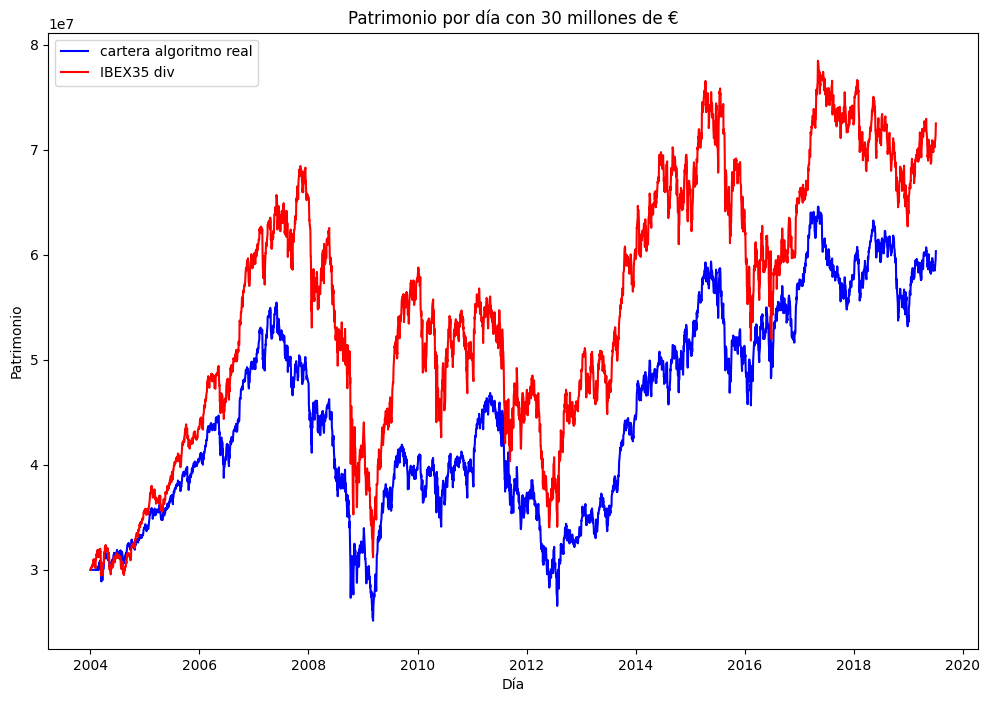

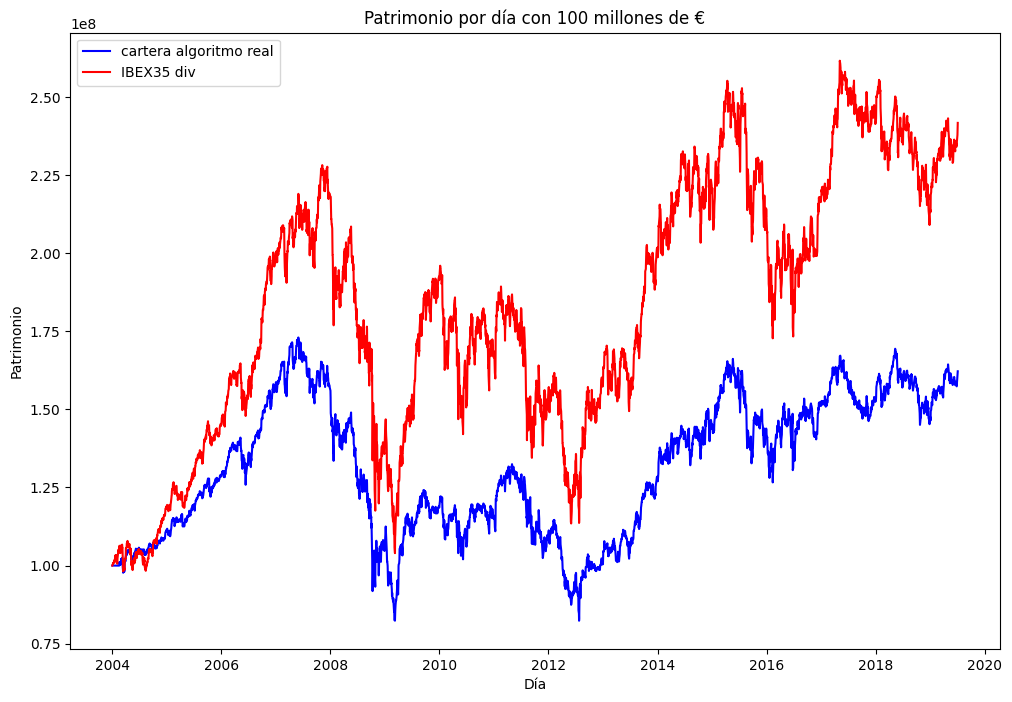

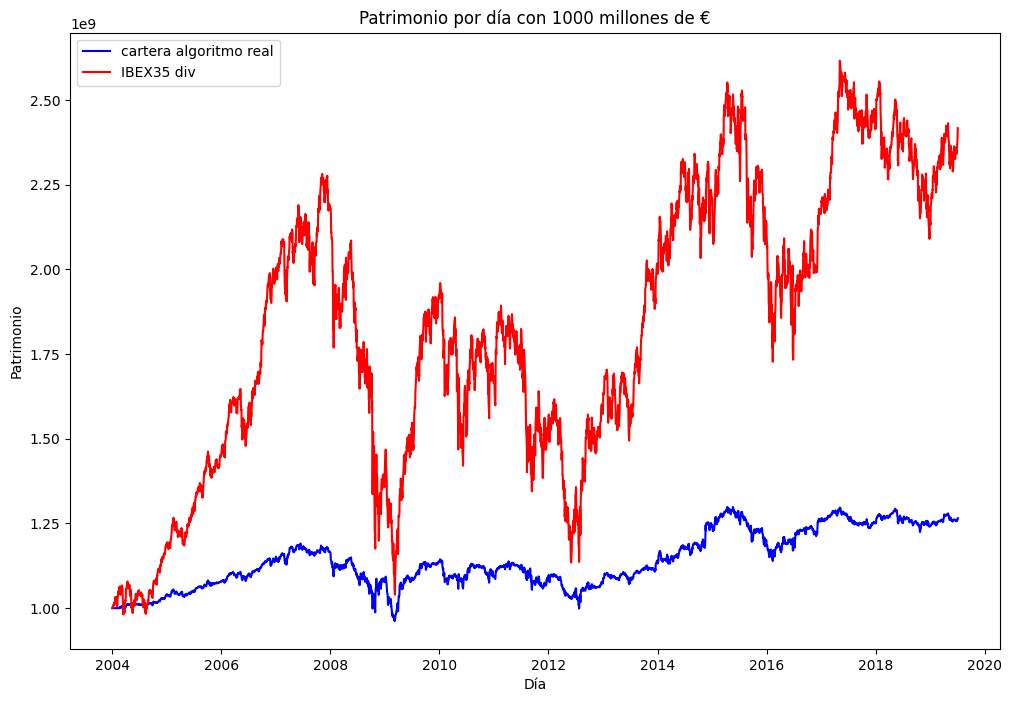

In [35]:
plot_patrimonio(real_cartera_30, stocks_ibex_close_data, real_cash_30, ibex35_index, 30_000_000)
plot_patrimonio(real_cartera_100, stocks_ibex_close_data, real_cash_100, ibex35_index, 100_000_000)
plot_patrimonio(real_cartera_1000, stocks_ibex_close_data, real_cash_1000, ibex35_index, 1_000_000_000)

**Comenta los resultados**

Como era de esperar, al tener un límite de asignación de compra que equivale a un % del volumen ejecutado del activo, cuanto más capital tengamos, más nos va a costar conseguir comprar o vender la cantidad deseada al completo. Es debido a esto que los resultados del algoritmo se "aplanan" al aumentar el capital disponible.

**Bloque 4**

Ahora, para la asignación de capital, únicamente emplearemos el límite de asignación. 

Sin embargo, no podremos introducir una órden que supere el límite calculado por umbral de arrastre. Si la órden es demasiado grande, tendrás que trocear las órdenes de compra - venta en varios días. Para este ejercicio estarás gestionando un capital de 100 millones de euros.

Comenta, ampliamente, los resultados y las implicaciones de tener que trocear las órdenes en varios días.

In [36]:
real_cartera_100_LA, real_cash_100_LA = ejecutar_algoritmo(real_senales,
                                            [stocks_ibex_close_data],
                                            [stocks_ibex_open_data],
                                            [stocks_ibex_volume_data],
                                            real_rankings,
                                            100_000_000,
                                            True) # este ultimo parametro permite seguir comprando si no se ha comprado el objetivo de acciones en un dia

Para este ejercicio hemos introducido la funcionalidad de, si no se consigue comprar el 100% de la cantidad deseada, se vuelve a comprar el restante al día siguiente hasta que se llegue al 100%.

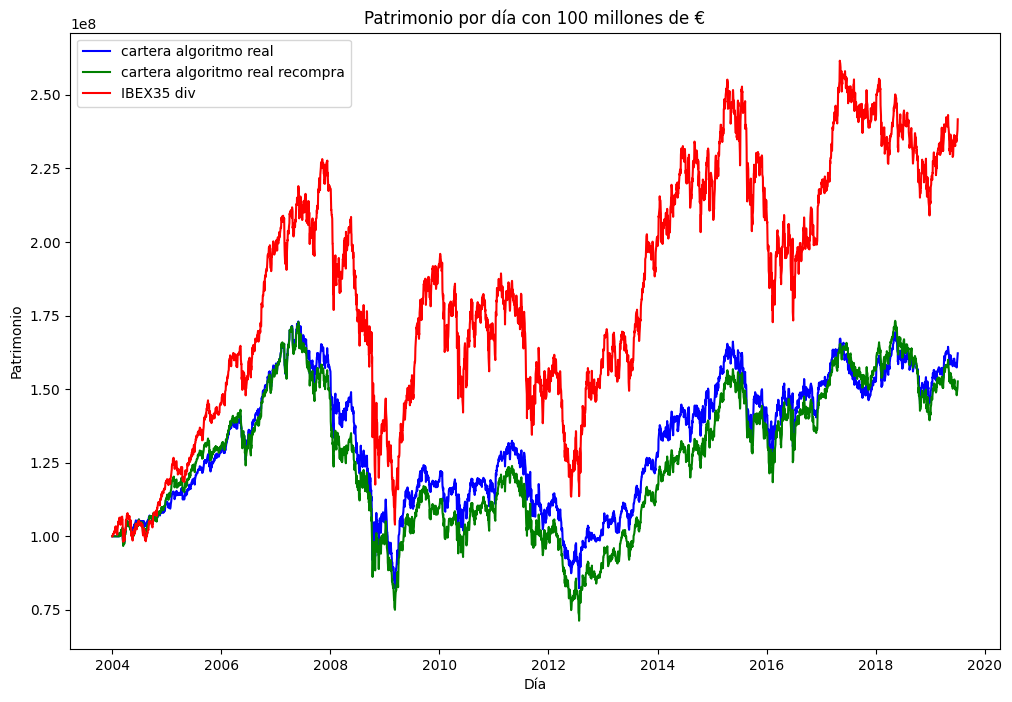

In [37]:
fig, ax = plt.subplots(figsize=(12, 8))
patrimonio = (real_cartera_100[0] * stocks_ibex_close_data).fillna(0).sum(axis=1) + real_cash_100[0]['capital_libre']
patrimonio_LA = (real_cartera_100_LA[0] * stocks_ibex_close_data).fillna(0).sum(axis=1) + real_cash_100_LA[0]['capital_libre']
ax.plot(patrimonio, 'b', label='cartera algoritmo real')
ax.plot(patrimonio_LA, 'g', label='cartera algoritmo real recompra')
patrimonio_ibex = ibex35_index['close'] * 100_000_000 / ibex35_index['close'].iloc[0]
ax.plot(patrimonio_ibex, 'r', label='IBEX35 div')
ax.set_xlabel('Día')
ax.set_ylabel('Patrimonio')
ax.set_title(f'Patrimonio por día con {int(100_000_000/1_000_000)} millones de €')
ax.legend()
plt.show()

In [38]:
# print std of returns patrimonio and return algo patrimonio_LA 
returns_algo_LA = patrimonio_LA.pct_change().dropna()
returns_algo = patrimonio.pct_change().dropna()
print(f"Volatilidad algoritmo SIN recompra: {np.round(returns_algo.std(), 4)}")
print(f"Volatilidad algoritmo CON recompra: {np.round(returns_algo_LA.std(), 4)}")

Volatilidad algoritmo SIN recompra: 0.0107
Volatilidad algoritmo CON recompra: 0.0116


**Comentario de los resultados**

Al ejecutar el algoritmo con recompra, se observa unos resultados bastante similares a los del algoritmo sin recompra. Esta diferencia probablemente e haga más notable al aumentar el capital a más de 100 millones. Sin embargo, sí que se puede notar que el algoritmo con recompra es ligeramente más volatil que el algorimo sin recompra, lo que tiene sentido debido a que el algoritmo de recompra debería de estar más invertido en acciones que en cash en comparación al algoritmo sin recompra y, en consecuencia, ser más volatil.

**Bloque 5**

Realiza este ejercicio con una configuración dinámica para los percentiles y la ventana, inciando los percentiles en 85 - 15 y la ventana en 30
    
En este apartado tienes que diseñar un sistema de configuración dinámica (no quiero que programes el sistema que desarrollamos en clase). Quiero que diseñes tu propio sistema con el objetivo de maximizar la eficiencia el algoritmo. El sistema que propongas debe modificar los percentiles de entrada, salida y ventana, para cada activo, cada día. El tamaño máximo de la ventana será de 100 días y el mínimo de 10. Siguiendo el espíritu de lo que aprendimos en clase, cada activo podrá estar en una configuración distinta cada día. 

Por ejemplo:

- Acciona (30/11/2016) 80 - 15 - 45
- Endesa  (30/11/2016) 74 - 12 - 49

Si quieres, puedes utilizar IA para este fin (algoritmos genéticos o enjambres)

Explica, con mucho detalle, el sistema que estás proponiendo al inicio de este bloque. 

Calcula el resultado del algoritmo para los datos sintéticos generados. 

Elije el sistema de configuración dinámico usando los datos sintéticos. 

Con el sistema de configuración dinámico ya seleccinado, calcula el resultado del algoritmo usando la serie histórica. Muestra los gráficos con 100 periodos aleatorios de 1 año, 100 de 3 años y 100 de 5 años. 

<center>
<img src="./imgs/resultado.png"  alt="drawing" width="1100"/>
</center>

Comenta, ampliamente, los resultados obtenidos y las ventajas, o desventajas, de usar configuraciones dinámicas vs configuraciones estáticas.

### Explicacion de la idea

La idea se basa en la premisa de persistencia/memoria larga de la volatilidad y la correlación entre volatilidad alta con "crashes" del mercado.

Nuestro algoritmo de inversion esta basado en una suposicion de regresión a la media según el alpha de Jensen. Para hacer nuestro algoritmo dinámico, vamos a hacer que en periodos de volatilidad relativa alta se va a dar más prioridad de compra a los activos menos volátiles (aumentando sus bandas superior e inferior una cantidad X proporcional a la volatilidad del momento) y menos a los activos volátiles. Con esto nuestra intención es reducir la volatilidad de nuestro algoritmo. Las bandas a partir de las cuales se compra y vende las vamos a hacer dinámicas de la siguiente forma: 

 1) Vamos a calcular un indicador de volatilidad que consistirá en un valor entre 0-1. Este valor se calcula como la posición relativa de la volatilidad actual con respecto a los ultimos 100 periodos. si la volatilidad hoy es la mayor de los últimos 100 días el valor será 1, si la volatilidad es justo la media de los últimos 100 días el valor sera 0.5, y si la volatilidad es la menor de los últimos días, el valor sera 0.

 2) A partir de este indicador vamos a sacar un valor proporcional el cual sumar/restar a los percentiles del alpha. Si el valor del indicador es 1, el rango a sumar/restar será un rango_indicador: {0.25, ..., -0.25} es decir, {indicador/4, ..., -indicador/4}. Ahora ordenaremos todos los activos según su volatilidad, de menor a mayor volatilidad y les asignamos unos percentiles que serán percentil_inferior_base + rango_indicador[i] y percentil_superior_base + rango_indicador[i]. De esta forma al primer activo, y menos volatil, se le sumara una cantidad que hará aumentar sus bandas de percentil de alfa y que hará que sea más facil que el algoritmo compre y más complicado que venda el activo. Al último activo, y más volatil, se le sumará una cantidad negativa, lo que hará que sea más dificil que el algoritmo compre y más complicado que venda el activo. De esta forma se fomenta que nuestro algoritmo este invertido en activos menos volátiles. Cuánta más volatilidad exista en el mercado, más agresivo será con esta selección de ativos menos volátiles.

 En resumen. Vamos a sumar/restar un valor a los percentiles que aplicaremos de los activos. Este valor será mayor cuanto mayor sea la volatilidad del mercado. Los valores a sumar/restar consisten en un rango {indicador/4, ..., -indicador/4}. A los activos menos volátiles se les sumara los valores mayores (positivos), mientras que a los activos más volátiles se les sumara los valores menores (negativos). Con esto nuestra intención es 1) reducir la volatilidad de nuestro algoritmo y 2) en los momentos de máxima volatilidad en donde el mercado cae (crashes) tratar de comprar activos que vayan a caer menos.

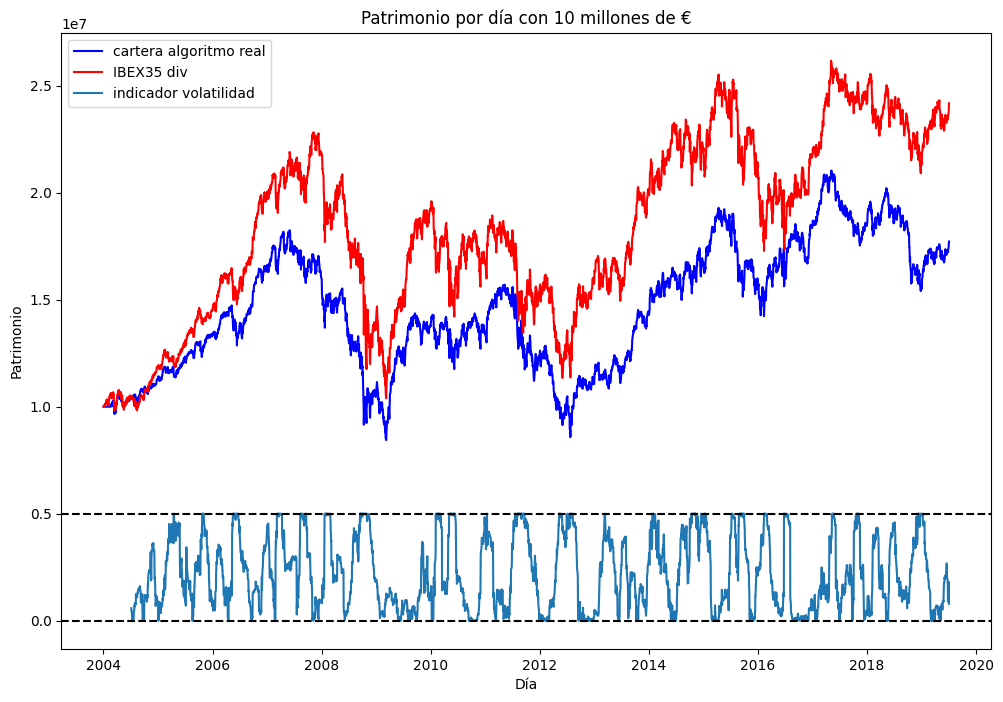

In [39]:
fig, ax = plt.subplots(figsize=(12, 8))
patrimonio = (real_cartera[0] * stocks_ibex_close_data).fillna(0).sum(axis=1) + real_cash[0]['capital_libre']
ax.plot(patrimonio, 'b', label='cartera algoritmo real')
patrimonio_ibex = ibex35_index['close'] * 10_000_000 / ibex35_index['close'].iloc[0]
ax.plot(patrimonio_ibex, 'r', label='IBEX35 div')
indicator = patrimonio_ibex.pct_change().rolling(30).std()
max_last_100 = indicator.rolling(100).max()
min_last_100 = indicator.rolling(100).min()
indicator = (indicator - min_last_100) / (max_last_100 - min_last_100)
ax.plot(indicator*0.5e7, label='indicador volatilidad')
ax.axhline(0, color='black', linestyle='--')
ax.axhline(0.5*1e7, color='black', linestyle='--')
ax.set_xlabel('Día')
ax.set_ylabel('Patrimonio')
ax.set_title(f'Patrimonio por día con {int(10_000_000/1_000_000)} millones de €')
ax.legend()
plt.show()

Se puede observar que el indicador toma valores mayores cuanto mayor es la volatilidad, tanto en los mementos de rentabilidades negativas como en los momentos de rentabilidades positivas. Calculemos la función para aplicar sumar/restar valores a los percentiles que aplicaremos en el algoritmo, según las volatilidades de los activos:

In [40]:
def apply_indicator(real_returns, indicador):
    """
    1 - hacemos un ranking de los activos cada dia segun su desviacion estandar de los ultimos 30 periodos
    2 - asignamos al DF de salida desde +indicator al primero hasta - indicator al ultimo de forma consecutiva (el segundo recibe algo menos de indicador, el tercero menos...)
    """
    ranking = pd.DataFrame(index=real_returns.index, columns=real_returns.columns, dtype=int)
    ranking.iloc[0] = 0
    ranking.iloc[1] = 0

    rolling_std = real_returns.rolling(30).std()

    for i in range(2, len(real_returns)):
        dia = real_returns.index[i]
        dia_anterior = real_returns.index[i - 1]

        rolling_yesterday = rolling_std.loc[dia_anterior]

        # ranking
        rolling_yesterday = rolling_yesterday[rolling_yesterday.notna()]
        rolling_yesterday = rolling_yesterday.sort_values(ascending=True)

        # Asignar valores al ranking según el indicador
        ranking.loc[dia] = 0
        valor = indicador.iloc[i]/2
        valor_a_restar = indicador.iloc[i] / len(rolling_yesterday)
        for j, activo in enumerate(rolling_yesterday.index):
            ranking.loc[dia, activo] = valor
            valor -= valor_a_restar
    
    return ranking
            
# test function
real_log_returns = np.log(stocks_ibex_close_data / stocks_ibex_close_data.shift(1))
real_returns = real_log_returns.copy()
real_returns = real_returns.loc[:, real_returns.columns != 'IBEX35']

indicador = patrimonio_ibex.pct_change().rolling(30).std()
max_last_100 = indicador.rolling(100).max()
min_last_100 = indicador.rolling(100).min()
indicador = (indicador - min_last_100) / (max_last_100 - min_last_100)

real_extra_alpha = apply_indicator(real_returns, indicador)
real_extra_alpha[100:]

ticker,A3TV,ABE,ABG,ABG.P_0,ABG.P_1,ACS,ACX,ACX_0,AENA,AGS,...,SGRE,SGRE_0,TEF,TEM,TL5,TRE,UNF,VIS,VIS_0,ZEL
date,,,,,,,,,,,,,,,,,,,,,
2004-05-26,0.0,NaN,0.0,0.0,0.0,NaN,0.000000,NaN,0.000000,0.0,...,0.000000,NaN,NaN,NaN,0.000000,0.0,NaN,0.000000,0.0,NaN
2004-05-27,0.0,NaN,0.0,0.0,0.0,NaN,0.000000,NaN,0.000000,0.0,...,0.000000,NaN,NaN,NaN,0.000000,0.0,NaN,0.000000,0.0,NaN
2004-05-28,0.0,NaN,0.0,0.0,0.0,NaN,0.000000,NaN,0.000000,0.0,...,0.000000,NaN,NaN,NaN,0.000000,0.0,NaN,0.000000,0.0,NaN
2004-05-31,0.0,NaN,0.0,0.0,0.0,NaN,0.000000,NaN,0.000000,0.0,...,0.000000,NaN,NaN,NaN,0.000000,0.0,NaN,0.000000,0.0,NaN
2004-06-01,0.0,NaN,0.0,0.0,0.0,NaN,0.000000,NaN,0.000000,0.0,...,0.000000,NaN,NaN,NaN,0.000000,0.0,NaN,0.000000,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-28,0.0,0.0,0.0,0.0,0.0,-2.255141e-17,-0.055766,0.0,0.043373,0.0,...,-0.068158,0.0,0.105336,0.0,-0.080551,0.0,0.0,0.086747,0.0,0.0
2019-07-01,0.0,0.0,0.0,0.0,0.0,-5.204170e-18,-0.050057,0.0,0.038933,0.0,...,-0.061181,0.0,0.094552,0.0,-0.077867,0.0,0.0,0.083428,0.0,0.0
2019-07-02,0.0,0.0,0.0,0.0,0.0,-2.255141e-17,-0.045738,0.0,0.040020,0.0,...,-0.051455,0.0,0.097192,0.0,-0.080041,0.0,0.0,0.085758,0.0,0.0


In [41]:
def calcular_percentiles_alfas_dfs(alfas_jensen, percentil_superior, percentil_inferior):
    """
    alfas_jensen = lista de DFs con los alfas de Jensen
    percentil_superior, percentil_inferior = DFs con los mismos índices y columnas que los alfas
    
    Devolvemos una lista de DFs en donde:
    - Si el alfa del activo en el día es mayor que el valor en percentil_superior, ponemos 1
    - Si el alfa del activo en el día es menor que el valor en percentil_inferior, ponemos -1
    - En otro caso, ponemos 0
    """
    lista_percentiles = []  
    
    for alfas in alfas_jensen:
        # Excluir la columna 'IBEX35' si existe
        alfas_sin_ibex = alfas.drop(columns=['IBEX35'], errors='ignore')
        
        # Filtrar los percentiles para usar solo las fechas correspondientes a este alfa
        ps_filtrado = percentil_superior.loc[alfas.index].drop(columns=['IBEX35'], errors='ignore')
        pi_filtrado = percentil_inferior.loc[alfas.index].drop(columns=['IBEX35'], errors='ignore')

        percentiles_dia = alfas_sin_ibex.rank(pct=True, axis=1)

        # Asignar valores según comparación directa con los percentiles
        percentiles = pd.DataFrame(
            np.select(
                [percentiles_dia > ps_filtrado, percentiles_dia < pi_filtrado],
                [1, -1], 
                default=0
            ),
            index=alfas.index,
            columns=alfas_sin_ibex.columns
        )

        lista_percentiles.append(percentiles)
    
    return lista_percentiles

In [42]:
# crear percentil superior (75+extra) y percentil inferior (25+extra) de los alfas
percentiles_superior = pd.DataFrame(index=real_extra_alpha.index, columns=real_extra_alpha.columns, dtype=float)
percentiles_inferior = pd.DataFrame(index=real_extra_alpha.index, columns=real_extra_alpha.columns, dtype=float)
percentiles_superior = percentiles_superior.fillna(0)
percentiles_inferior = percentiles_inferior.fillna(0)
for i in range(len(real_extra_alpha)):
    percentiles_superior.iloc[i] =  real_extra_alpha.iloc[i]/2 + 0.85
    percentiles_inferior.iloc[i] =  real_extra_alpha.iloc[i]/2 + 0.15

real_alpha = calcular_alfa_Jensen([stocks_ibex_close_data],  eonia['Eonia'])
real_rankings = ranking_3meses([stocks_ibex_close_data], [stocks_ibex_volume_data])
real_percentiles_df = calcular_percentiles_alfas_dfs(real_alpha, percentiles_superior, percentiles_inferior)
real_senales  = generar_senales(real_percentiles_df)
real_cartera, real_cash = ejecutar_algoritmo(real_senales,
                                            [stocks_ibex_close_data],
                                            [stocks_ibex_open_data],
                                            [stocks_ibex_volume_data],
                                            real_rankings)

c:\Users\danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


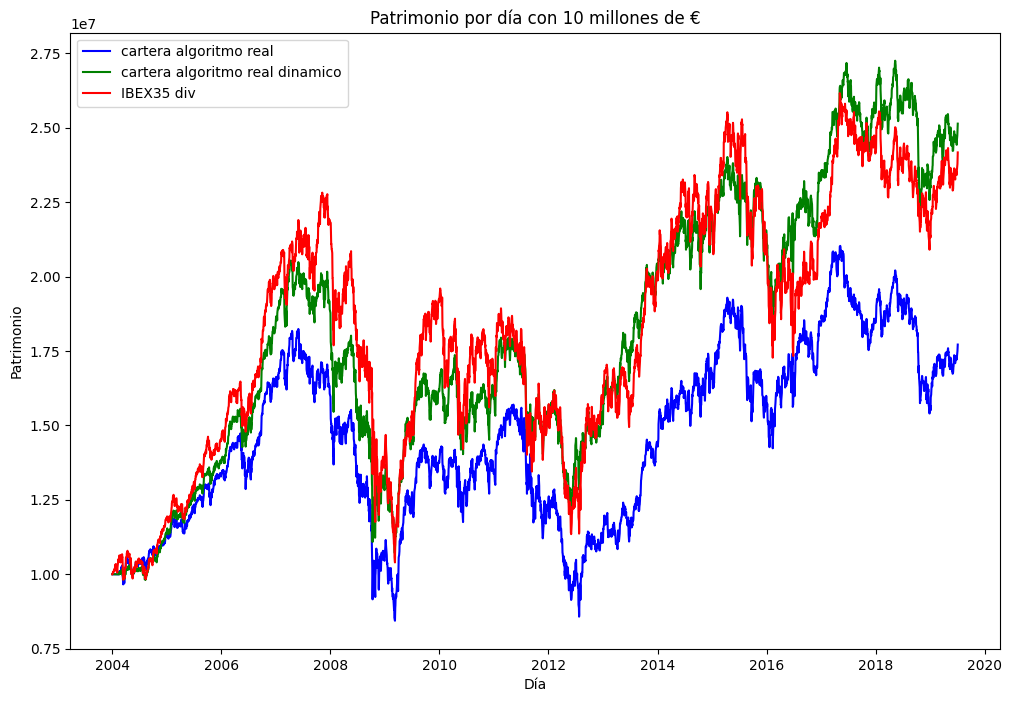

In [43]:
# plot patrimonio vs ibex
fig, ax = plt.subplots(figsize=(12, 8))
patrimonio_dinamico = (real_cartera[0] * stocks_ibex_close_data).fillna(0).sum(axis=1) + real_cash[0]['capital_libre']
patrimonio_ibex = ibex35_index['close'] * 10_000_000 / ibex35_index['close'].iloc[0]
ax.plot(patrimonio, 'b', label='cartera algoritmo real')
ax.plot(patrimonio_dinamico, 'g', label='cartera algoritmo real dinamico')
ax.plot(patrimonio_ibex, 'r', label='IBEX35 div')
ax.set_xlabel('Día')
ax.set_ylabel('Patrimonio')
ax.set_title(f'Patrimonio por día con {int(10_000_000/1_000_000)} millones de €')
ax.legend()
plt.show()

Podemos observar que el algoritmo dinámico supera al algoritmo estático. Sin embargo, acaba obteniendo resultados muy parecidos al ibex con dividendos.

In [59]:
# print los std del patrimonio dinamico, patrimonio y el ibex
returns_algo_dinamico = patrimonio_dinamico.pct_change().dropna()
returns_algo = patrimonio.pct_change().dropna()
returns_ibex = patrimonio_ibex.pct_change().dropna()
print(f"Volatilidad algoritmo SIN dinamico: {np.round(returns_algo.std(), 4)}")
print(f"Volatilidad algoritmo CON dinamico: {np.round(returns_algo_dinamico.std(), 4)}")
print(f"Volatilidad IBEX35: {np.round(returns_ibex.std(), 4)}")

# print los retornos del patrimonio dinamico, patrimonio y el ibex
total_return_algo = (patrimonio.iloc[-1] - patrimonio.iloc[0]) / patrimonio.iloc[0]
total_return_algo_dinamico = (patrimonio_dinamico.iloc[-1] - patrimonio_dinamico.iloc[0]) / patrimonio_dinamico.iloc[0]
total_return_ibex = (patrimonio_ibex.iloc[-1] - patrimonio_ibex.iloc[0]) / patrimonio_ibex.iloc[0]
print(f"Retorno algoritmo SIN dinamico: {np.round(total_return_algo * 100, 2)}%")
print(f"Retorno algoritmo CON dinamico: {np.round(total_return_algo_dinamico * 100, 2)}%")
print(f"Retorno IBEX35: {np.round(total_return_ibex * 100, 2)}%")

Volatilidad algoritmo SIN dinamico: 0.012
Volatilidad algoritmo CON dinamico: 0.011
Volatilidad IBEX35: 0.014
Retorno algoritmo SIN dinamico: 77.16%
Retorno algoritmo CON dinamico: 151.38%
Retorno IBEX35: 141.71%


Podemos observar cómo hemos conseguido reducir la volatilidad del algoritmo ligeramente a la vez que hemos conseguido aumentar su rentabilidad.

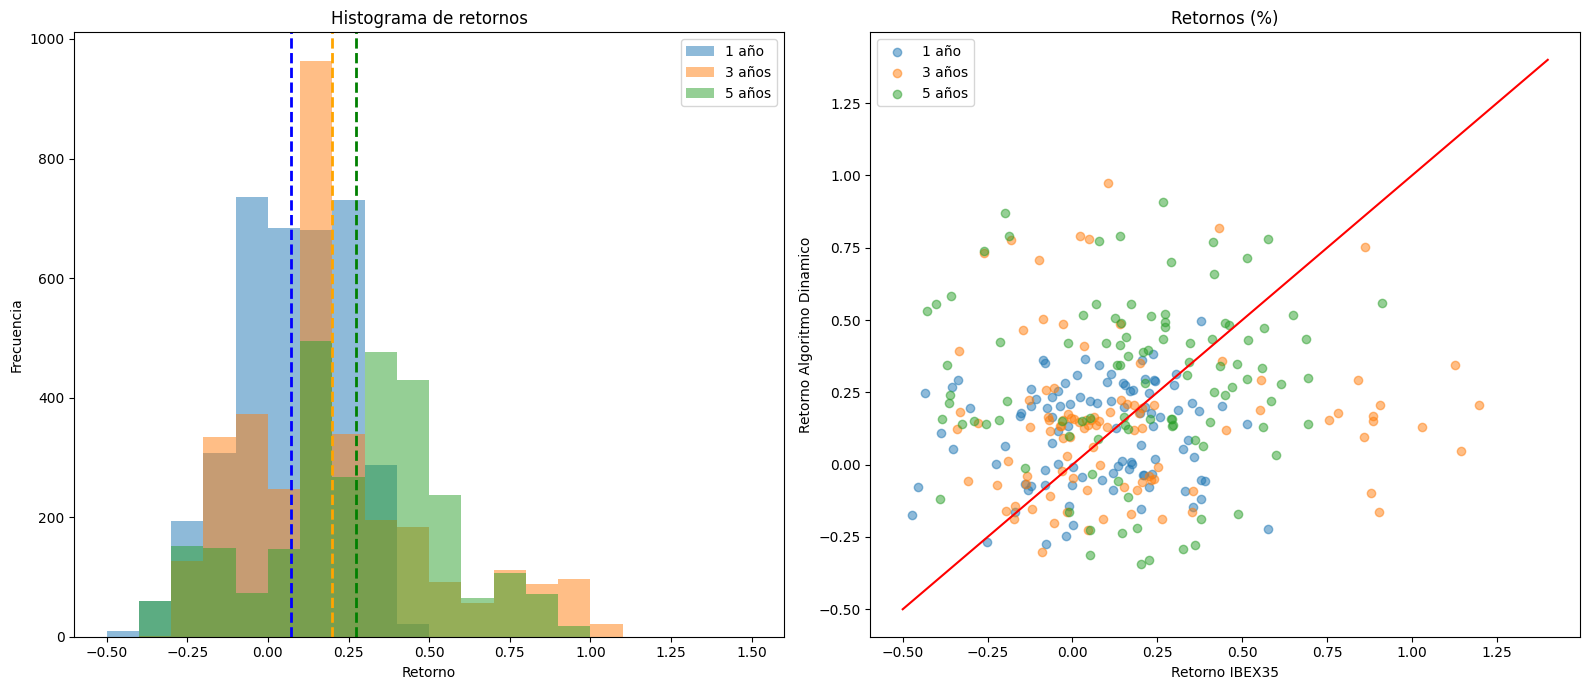

In [55]:
# Cálculo de periodos de 1-3-5 años del rolling del patrimonio y del IBEX
patrimonio_algo_real = (real_cartera[0] * stocks_ibex_close_data).fillna(0).sum(axis=1) + real_cash[0]['capital_libre']
returns_algo_1 = (patrimonio_algo_real[242:].values - patrimonio_algo_real[:-242].values) / patrimonio_algo_real[:-242].values
returns_algo_3 = (patrimonio_algo_real[726:].values - patrimonio_algo_real[:-726].values) / patrimonio_algo_real[:-726].values
returns_algo_5 = (patrimonio_algo_real[1210:].values - patrimonio_algo_real[:-1210].values) / patrimonio_algo_real[:-1210].values
returns_ibex_1 = (ibex35_index['close'][242:].values - ibex35_index['close'][:-242].values) / ibex35_index['close'][:-242].values
returns_ibex_3 = (ibex35_index['close'][726:].values - ibex35_index['close'][:-726].values) / ibex35_index['close'][:-726].values
returns_ibex_5 = (ibex35_index['close'][1210:].values - ibex35_index['close'][:-1210].values) / ibex35_index['close'][:-1210].values

# plot histograms of returns_algo 1 3 5 and another scatter graph
fig, axs = plt.subplots(1, 2, figsize=(16, 7))
axs[0].hist(returns_algo_1, bins=20, alpha=0.5, label='1 año', range=(-0.5, 1.5))
axs[0].hist(returns_algo_3, bins=20, alpha=0.5, label='3 años', range=(-0.5, 1.5))
axs[0].hist(returns_algo_5, bins=20, alpha=0.5, label='5 años', range=(-0.5, 1.5))
axs[0].set_xlabel('Retorno')
axs[0].set_ylabel('Frecuencia')
axs[0].set_title('Histograma de retornos')
axs[0].legend()
axs[0].axvline(np.mean(returns_algo_1), color='blue', linestyle='dashed', linewidth=2)
axs[0].axvline(np.mean(returns_algo_3), color='orange', linestyle='dashed', linewidth=2)
axs[0].axvline(np.mean(returns_algo_5), color='green', linestyle='dashed', linewidth=2)

returns_ibex_1_random_100 = np.random.choice(returns_ibex_1, 100)
returns_ibex_3_random_100 = np.random.choice(returns_ibex_3, 100)
returns_ibex_5_random_100 = np.random.choice(returns_ibex_5, 100)
returns_algo_5_random_100 = np.random.choice(returns_algo_5, 100)
returns_algo_3_random_100 = np.random.choice(returns_algo_3, 100)
returns_algo_1_random_100 = np.random.choice(returns_algo_1, 100)

axs[1].scatter(returns_ibex_1_random_100, returns_algo_1_random_100, label='1 año', alpha=0.5)
axs[1].scatter(returns_ibex_3_random_100, returns_algo_3_random_100, label='3 años', alpha=0.5)
axs[1].scatter(returns_ibex_5_random_100, returns_algo_5_random_100, label='5 años', alpha=0.5)
axs[1].plot([-0.5, 1.4], [-0.5, 1.4], 'r')
axs[1].set_xlabel('Retorno IBEX35')
axs[1].set_ylabel('Retorno Algoritmo Dinamico')
axs[1].set_title('Retornos (%)')
axs[1].legend()
plt.tight_layout()
plt.show()

### Comentarios

Como es de esperar, en la gráfica de los histogramas se observa cómo la media de los retornos es ligeramenre superior que las medias de el algoritmo no dinámico. Sin embargo, en el gráfico de puntos no se observa la existencia de una ventaja de nuestr algoritmo con respecto al ibex con dividendos